<a href="https://colab.research.google.com/github/Vlasovets/Deep_learning_course_assistantship/blob/master/Generative_adversarial_network(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced topics in User Interfaces

## 🧐 **Learning goals** 
You will learn how to implement the pix2pix GAN, and concretely:
- How to build a PatchGAN discriminator (D) model.
- How to build a U-Net generator (G) model.
- How to combine D and G to create the pix2pix model.

## 🔑1. Introduction

💡Idea: Generative adversarial networks (GANs) are generative models that create new data instances that resemble your training data.

The GAN architecture was first described in the 2014 paper by Ian Goodfellow, et al. titled “[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661).”

In [3]:
from IPython.display import Image
Image(url='https://sigmoidal.io/wp-content/uploads/2017/09/generator_and_discriminator1.png')

GANs have two parts:

* <font color=lightgreen>generator</font> learns to generate plausible data. 

* <font color=pink>discriminator</font> learns to distinguish true data from the output of the generator. 

The generated instances become negative training examples for the discriminator.
The discriminator penalizes the generator for producing implausible results.
Informally, the generator tries to fool the discriminator, and the discriminator tries to keep from being fooled.

Both the generator and the discriminator are <font color=lightblue>neural networks</font>. The generator output is connected directly to the discriminator input. Through [backpropagation](https://www.youtube.com/watch?v=Ilg3gGewQ5U), the discriminator's classification provides a signal that the generator uses to update its weights. 

🔎Find many examples of GANs [here](https://thisxdoesnotexist.com/).

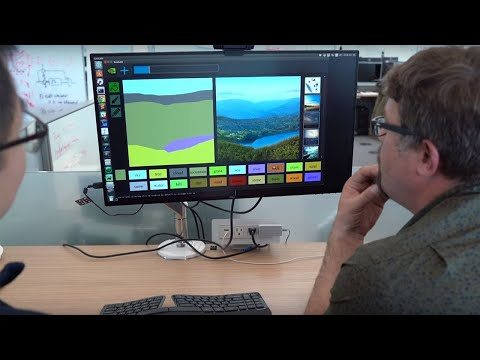

In [10]:
from IPython.display import YouTubeVideo
YouTubeVideo('p5U4NgVGAwg')

## ⚙️ 2. Generator 

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator. It learns to make the discriminator classify its output as real.

<font color=lightgreen>The generator includes</font>:

 - random input
 - generator network, which transforms the random input into a data instance
 - discriminator network, which classifies the generated data
 - discriminator output
 - generator loss, which penalizes the generator for failing to fool the discriminator

## ⚖️ 3. Discriminator

The discriminator connects to two loss functions.
 
You can find a very practical tutorial on how to choose the loss function for your deep neural network architecture [here](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/).

During discriminator training,the discriminator ignores the generator loss and just uses the discriminator loss. We use the generator loss only during generator training.

<font color=pink>During discriminator training:</font>

 - The discriminator classifies both real data and fake data from the generator.
 - The discriminator loss penalizes the discriminator for misclassifying a real instance as fake or a fake instance as real.
 - The discriminator updates its weights through backpropagation from the discriminator loss through the discriminator network.

##  🗺️ 4. Data

🚩 The data contains satelite images from the Google Maps.

You can upload the data by executing  the following commands:

In [0]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz

In [0]:
!tar -zxvf maps.tar.gz

Import all necessary libraries for this exercise.

In [7]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, io, transform
from glob import glob

If you use GPU, you might need to set the following configuration.

Note, the following code block is optinal and does not require running if you do not use a GPU.

In [8]:
import tensorflow.compat.v1 as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

In [0]:
class MapsLoader():
    # This class needs to know the input shape, as usual.
    def __init__(self, img_shape):
        self.img_shape = img_shape

    # This method reads the path to train/val map images.
    def load_paths(self, from_train_partition=False):
        data_type = 'train' if from_train_partition else 'val'
        pattern = './maps/{}/*'.format(data_type)
        return glob(pattern)

    # This method loads some images, defined by the `batch_size` arg,
    # which is the number of images to load.
    def load_batch(self, batch_size=1, from_train_partition=False):
        image_paths = self.load_paths(from_train_partition)
        batch_images = np.random.choice(image_paths, size=batch_size)
        return self.load_images(batch_images)

    # This generator loads some images, defined by the `batch_size` arg,
    # which is the number of images to load.
    def batch_generator(self, batch_size=1, from_train_partition=False):
        image_paths = self.load_paths(from_train_partition)
        n_batches = len(image_paths) // batch_size
        for i in range(n_batches - 1):
            batch_images = image_paths[i*batch_size : (i+1)*batch_size]
            yield self.load_images(batch_images)

    # This method loads some images, defined by the `batch_images` arg,
    # which is a list of image files.
    def load_images(self, batch_images):
        real_A = [] # satellite image
        real_B = [] # map image
        for img_path in batch_images:
            img = self.imread(img_path)
            # In this dataset A and B are in the same image file, so split them.
            h, w = img.shape[0:2]
            half_w = w // 2
            img_A = img[:, :half_w, :]
            img_B = img[:, half_w:, :]
            img_A = self.imresize(img_A, self.img_shape[0:2])
            img_B = self.imresize(img_B, self.img_shape[0:2])
            real_A.append(img_A)
            real_B.append(img_B)
        return np.array(real_A), np.array(real_B)

    # This function reads an image from given path and return normalized pixel values, in [0,1].
    # See https://scikit-image.org/docs/dev/api/skimage.html
    def imread(self, path):
        fh = io.imread(path, as_gray=False)
        return img_as_float(fh)

    # This function resizes an img (ndarray) to the given shape.
    # See https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    def imresize(self, img, shape):
        return transform.resize(img, shape, mode='symmetric', preserve_range=True)

## ⚡5. GAN Training

The key difference of GANs from the previous models we studied:

❗ We train two neural networks  at the same time.

In [9]:
class Pix2Pix():
    # This class needs to know the input shape, as usual.
    def __init__(self, img_shape):
        self.img_shape = img_shape
        self.dataset = MapsLoader(img_shape=img_shape)

        # The discriminator network is implemented as a PatchGAN (convnet).
        # A PatchGAN discriminator classifies individual NxN patches in the image as real vs. fake,
        # instead of classifying the *entire image* as real vs. fake; see Section 3.2.2 in https://arxiv.org/pdf/1611.07004.pdf
        # The pix2pix authors found that this produces sharper images and requires less computations.
        height, width = img_shape[0:2]
        h_patch = int(height / 2**4)
        w_patch = int(width / 2**4)
        self.disc_patch = (h_patch, w_patch, 1)

        # Number of filters for the first layer of the Generator (G) and Discriminator (D).
        # In convents, this is also know as the "receptive field" of the network.
        self.gf = 64 # num G filters
        self.df = 64 # num D filters

        # Let's use different optimizers for D and G, since often D overrules G.
        d_opt = tf.keras.optimizers.Adam(lr=0.005)
        g_opt = tf.keras.optimizers.Adam(lr=0.00001)

        self.discriminator = self.build_discriminator()

        # We want to train G *only* for the combined model (i.e. the GAN), so let's make D non-trainable *after* compiling D.
        # This way, D can still learn during D.train_on_batch() but the combined model will update only G during GAN.train_on_batch().
        self.discriminator.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=['accuracy'])
        self.discriminator.trainable = False

        self.generator = self.build_generator()

        # The goal is to produce a fake image that looks like a real one (in this case, a satellite image),
        # conditioned to some input image (in this case, a map image).
        real_img = tf.keras.layers.Input(shape=self.img_shape)
        fake_img = self.generator(real_img)
        eval_res = self.discriminator([real_img, fake_img])

        # Define the GAN model.
        self.model = tf.keras.Model(inputs=real_img, outputs=[eval_res, fake_img])
        self.model.compile(loss=['mse', 'mae'], optimizer=g_opt)


    # The discriminator uses a simple convnet model.
    def build_discriminator(self):
        # Auxiliary function to define a downsampling block.
        def conv2d(layer_input, num_filters, filter_size=4, batchnorm=True):
            d = tf.keras.layers.Conv2D(num_filters, kernel_size=filter_size, strides=2, padding='same')(layer_input)
            if batchnorm:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            return d

        # Remember: A is the satellite image (source) and B is the map image (target).
        img_A = tf.keras.layers.Input(shape=self.img_shape)
        img_B = tf.keras.layers.Input(shape=self.img_shape)

        # The input is a list of 2 images, and the goal is to classify them correctly.
        imput_layer = tf.keras.layers.Concatenate()([img_A, img_B])

        # Authors mentioned that batch normalization is not used in the first layer.
        d1 = conv2d(imput_layer, self.df, batchnorm=False)
        d2 = conv2d(d1, self.df*2)
        d3 = conv2d(d2, self.df*4)
        d4 = conv2d(d3, self.df*8)

        # Be careful with image shape, since it changes after each convolutional block.
        output_layer = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same', activation='sigmoid')(d4)

        return tf.keras.Model([img_A, img_B], output_layer)


    # The generator is a U-Net model.
    def build_generator(self):
        # Auxiliary function to define a downsampling block.
        def conv2d(layer_input, num_filters, filter_size=4, batchnorm=True):
            d = tf.keras.layers.Conv2D(num_filters, kernel_size=filter_size, strides=2, padding='same')(layer_input)
            if batchnorm:
                d = tf.keras.layers.BatchNormalization(momentum=0.8)(d)
            d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
            return d

        # Auxiliary function to define an upsampling block.
        def deconv2d(layer_input, skip_input, num_filters, filter_size=4, dropout=True):
            u = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size=filter_size, strides=2, padding='same', activation='relu')(layer_input)
            u = tf.keras.layers.BatchNormalization(momentum=0.8)(u)
            if dropout:
                u = tf.keras.layers.Dropout(0.25)(u)
            u = tf.keras.layers.Concatenate(axis=-1)([u, skip_input])
            return u

        # The input is a map image, and G will "hallucinate" a satellite image.
        input_layer = tf.keras.layers.Input(shape=self.img_shape)

        # Downsampling blocks.
        # Authors mentioned that batch normalization is not used in the first layer.
        d1 = conv2d(input_layer, self.gf, batchnorm=False)
        d2 = conv2d(d1, self.gf*2)
        d3 = conv2d(d2, self.gf*4)
        d4 = conv2d(d3, self.gf*8)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)

        # Bottleneck layer: no batch normalization and relu activation instead of leaky relu.
        b1 = tf.keras.layers.Conv2D(self.gf*8, kernel_size=4, strides=2, padding='same', activation='relu')(d6)

        # Upsampling blocks.
        u1 = deconv2d(b1, d6, self.gf*8)
        u2 = deconv2d(u1, d5, self.gf*8)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*4)
        u5 = deconv2d(u4, d2, self.gf*2)
        u6 = deconv2d(u5, d1, self.gf)

        # Output layer. Remember to get the right image shape back.
        output_layer = tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='relu')(u6)

        return tf.keras.Model(input_layer, output_layer)


    def train(self, num_epochs, batch_size=1, sample_interval=50):
        # Initialize class labels: real (1) and fake (0) images.
        # NB: Some authors recommend to use "soft labels" to improve training stability.
        y_real = np.ones((batch_size,) + self.disc_patch)
        y_fake = np.zeros((batch_size,) + self.disc_patch)

        for epoch in range(num_epochs):
            # Remember: A is the satellite image (source) and B is the map image (target).
            for batch_i, (real_A, real_B) in enumerate(self.dataset.batch_generator(batch_size)):
                # Train Discriminator.
                # Remember that G will take as input a map image (B) and generate a realistic satellite image (A).
                fake_A = self.generator.predict(real_B)
                # Update D loss for real samples, then for fake samples, finally aggregate loss.
                d_loss_real = self.discriminator.train_on_batch([real_A, real_B], y_real)
                d_loss_fake = self.discriminator.train_on_batch([fake_A, real_B], y_fake)
                # Averaging the losses slows down the rate at which D learns relative to G.
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Train Generator.
                # Remember that the goal is to generate a satellite image (A) from a map image (B).
                g_loss = self.model.train_on_batch(real_B, [y_real, real_A])

                # Save results regularly.
                if batch_i % sample_interval == 0:
                    self.save_images(epoch, batch_i)

                # Plot progress.
                msg = 'Epoch {}/{} | Batch {:04d} | D loss: {:.5f} D acc: {:.2f} | G
                loss: {:.5f}'
                print(msg.format(epoch, num_epochs, batch_i,
                d_loss[0], d_loss[1], g_loss[0]))


    # Write results as a 3x3 grid, where each row is: source (condition), generation, and ground-truth.
    # This way we can visually inspect the progress at regular checkpoints.
    def save_images(self, epoch, batch_i):
        out_path = './maps/outputs'
        if not os.path.exists(out_path):
            os.makedirs(out_path)

        # Remember: A is the satellite image (source) and B is the map image (target).
        real_A, real_B = self.dataset.load_batch(batch_size=3, from_train_partition=False)
        # Remember that G will take as input a map image (B) and generate a realistic satellite image (A).
        fake_A = self.generator.predict(real_B)

        implot = np.concatenate([real_B, fake_A, real_A])
        implot = 0.5 * implot + 0.5 # rescale images in [0,1]

        titles = ['Condition', 'Generated', 'Original']
        rows, cols = 3, 3
        fig, axs = plt.subplots(rows, cols)
        cnt = 0
        for i in range(rows):
            for j in range(cols):
                axs[i,j].imshow(implot[cnt])
                axs[i,j].set_title(titles[i], {'fontsize': 9})
                axs[i,j].axis('off')
                cnt += 1
        out_file = '{}/{:04d}_{:04d}.png'.format(out_path, epoch, batch_i)
        print('Checkpoint images saved in {}'.format(out_file))
        fig.savefig(out_file)
        plt.close()


if __name__ == '__main__':
    # The maps dataset has 600x600 color images, which will make the training process slow, especially in CPU.
    # So let's work with smaller resolution files to speed up training.
    IMG_SHAPE = (128, 128, 3)

    GAN = Pix2Pix(img_shape=IMG_SHAPE)
    GAN.train(num_epochs=100, batch_size=2, sample_interval=50)
    GAN.model.save('map2sat.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Checkpoint images saved in ./maps/outputs/0000_0000.png
Epoch 0/100 | Batch 0000 | D loss: 7.05394 | G loss: 0.33506
Epoch 0/100 | Batch 0001 | D loss: 3.10027 | G loss: 0.55624
Epoch 0/100 | Batch 0002 | D loss: 0.59765 | G loss: 1.14681
Epoch 0/100 | Batch 0003 | D loss: 1.30690 | G loss: 0.87618
Epoch 0/100 | Batch 0004 | D loss: 1.31184 | G loss: 0.57943
Epoch 0/100 | Batch 0005 | D loss: 0.89283 | G loss: 0.51711
Epoch 0/100 | Batch 0006 | D loss: 0.85801 | G loss: 0.46408
Epoch 0/100 | Batch 0007 | D loss: 0.47834 | G loss: 0.92252
Epoch 0/100 | Batch 0008 | D loss: 1.03051 | G loss: 0.81656
Epoch 0/100 | Batch 0009 | D loss: 0.92323 | G loss: 0.64028
Epoch 0/100 | Batch 0010 | D loss: 0.75572 | G loss: 0.61590
Epoch 0/100 | Batch 0011 | D loss: 0.42038 | G loss: 0.99325
Epoch 0/100 | Batch 0012 | D loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0050.png
Epoch 0/100 | Batch 0050 | D loss: 1.29465 | G loss: 1.24652
Epoch 0/100 | Batch 0051 | D loss: 1.85319 | G loss: 0.75331
Epoch 0/100 | Batch 0052 | D loss: 1.46563 | G loss: 0.54217
Epoch 0/100 | Batch 0053 | D loss: 0.40109 | G loss: 0.49335
Epoch 0/100 | Batch 0054 | D loss: 0.46882 | G loss: 1.03612
Epoch 0/100 | Batch 0055 | D loss: 0.61477 | G loss: 1.12065
Epoch 0/100 | Batch 0056 | D loss: 0.16578 | G loss: 0.35821
Epoch 0/100 | Batch 0057 | D loss: 0.10412 | G loss: 1.09632
Epoch 0/100 | Batch 0058 | D loss: 0.14757 | G loss: 0.41514
Epoch 0/100 | Batch 0059 | D loss: 0.08318 | G loss: 0.29465
Epoch 0/100 | Batch 0060 | D loss: 0.04012 | G loss: 0.65945
Epoch 0/100 | Batch 0061 | D loss: 0.03710 | G loss: 0.77440
Epoch 0/100 | Batch 0062 | D loss: 0.04477 | G loss: 0.58371
Epoch 0/100 | Batch 0063 | D loss: 0.02547 | G loss: 0.60556
Epoch 0/100 | Batch 0064 | D loss: 0.06162 | G loss: 0.31405
Epoch 0/100 | Batch 0065 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0100.png
Epoch 0/100 | Batch 0100 | D loss: 0.00328 | G loss: 0.29654
Epoch 0/100 | Batch 0101 | D loss: 0.00289 | G loss: 0.28875
Epoch 0/100 | Batch 0102 | D loss: 0.00254 | G loss: 0.27242
Epoch 0/100 | Batch 0103 | D loss: 0.00522 | G loss: 0.26373
Epoch 0/100 | Batch 0104 | D loss: 0.00263 | G loss: 0.37446
Epoch 0/100 | Batch 0105 | D loss: 0.00191 | G loss: 0.31594
Epoch 0/100 | Batch 0106 | D loss: 0.00539 | G loss: 0.36946
Epoch 0/100 | Batch 0107 | D loss: 0.00313 | G loss: 0.27695
Epoch 0/100 | Batch 0108 | D loss: 0.00534 | G loss: 0.32424
Epoch 0/100 | Batch 0109 | D loss: 0.00121 | G loss: 0.29829
Epoch 0/100 | Batch 0110 | D loss: 0.00060 | G loss: 0.31725
Epoch 0/100 | Batch 0111 | D loss: 0.00111 | G loss: 0.33981
Epoch 0/100 | Batch 0112 | D loss: 0.00133 | G loss: 0.29751
Epoch 0/100 | Batch 0113 | D loss: 0.00376 | G loss: 0.28840
Epoch 0/100 | Batch 0114 | D loss: 0.01197 | G loss: 0.31185
Epoch 0/100 | Batch 0115 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0150.png
Epoch 0/100 | Batch 0150 | D loss: 0.00030 | G loss: 0.30442
Epoch 0/100 | Batch 0151 | D loss: 0.01379 | G loss: 0.28688
Epoch 0/100 | Batch 0152 | D loss: 0.00048 | G loss: 0.27411
Epoch 0/100 | Batch 0153 | D loss: 0.00053 | G loss: 0.31096
Epoch 0/100 | Batch 0154 | D loss: 0.00105 | G loss: 0.32526
Epoch 0/100 | Batch 0155 | D loss: 0.00088 | G loss: 0.29600
Epoch 0/100 | Batch 0156 | D loss: 0.00050 | G loss: 0.28350
Epoch 0/100 | Batch 0157 | D loss: 0.00261 | G loss: 0.27916
Epoch 0/100 | Batch 0158 | D loss: 0.00187 | G loss: 0.31462
Epoch 0/100 | Batch 0159 | D loss: 0.00102 | G loss: 0.33800
Epoch 0/100 | Batch 0160 | D loss: 0.00084 | G loss: 0.30602
Epoch 0/100 | Batch 0161 | D loss: 0.00137 | G loss: 0.27824
Epoch 0/100 | Batch 0162 | D loss: 0.00097 | G loss: 0.25466
Epoch 0/100 | Batch 0163 | D loss: 0.00171 | G loss: 0.33995
Epoch 0/100 | Batch 0164 | D loss: 0.00100 | G loss: 0.35755
Epoch 0/100 | Batch 0165 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0200.png
Epoch 0/100 | Batch 0200 | D loss: 0.00374 | G loss: 0.23417
Epoch 0/100 | Batch 0201 | D loss: 0.00116 | G loss: 0.29989
Epoch 0/100 | Batch 0202 | D loss: 0.00031 | G loss: 0.32130
Epoch 0/100 | Batch 0203 | D loss: 0.00269 | G loss: 0.27360
Epoch 0/100 | Batch 0204 | D loss: 0.00036 | G loss: 0.29019
Epoch 0/100 | Batch 0205 | D loss: 0.00029 | G loss: 0.30108
Epoch 0/100 | Batch 0206 | D loss: 0.00032 | G loss: 0.28162
Epoch 0/100 | Batch 0207 | D loss: 0.00035 | G loss: 0.29583
Epoch 0/100 | Batch 0208 | D loss: 0.00025 | G loss: 0.33597
Epoch 0/100 | Batch 0209 | D loss: 0.00041 | G loss: 0.26390
Epoch 0/100 | Batch 0210 | D loss: 0.00080 | G loss: 0.31149
Epoch 0/100 | Batch 0211 | D loss: 0.00043 | G loss: 0.27506
Epoch 0/100 | Batch 0212 | D loss: 0.00031 | G loss: 0.31325
Epoch 0/100 | Batch 0213 | D loss: 0.00036 | G loss: 0.28530
Epoch 0/100 | Batch 0214 | D loss: 0.00018 | G loss: 0.28056
Epoch 0/100 | Batch 0215 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0250.png
Epoch 0/100 | Batch 0250 | D loss: 0.00024 | G loss: 0.29742
Epoch 0/100 | Batch 0251 | D loss: 0.00033 | G loss: 0.32077
Epoch 0/100 | Batch 0252 | D loss: 0.00117 | G loss: 0.30159
Epoch 0/100 | Batch 0253 | D loss: 0.00029 | G loss: 0.23607
Epoch 0/100 | Batch 0254 | D loss: 0.00018 | G loss: 0.31503
Epoch 0/100 | Batch 0255 | D loss: 0.00062 | G loss: 0.27036
Epoch 0/100 | Batch 0256 | D loss: 0.00017 | G loss: 0.32636
Epoch 0/100 | Batch 0257 | D loss: 0.00055 | G loss: 0.26370
Epoch 0/100 | Batch 0258 | D loss: 0.00046 | G loss: 0.27459
Epoch 0/100 | Batch 0259 | D loss: 0.00013 | G loss: 0.31178
Epoch 0/100 | Batch 0260 | D loss: 0.00014 | G loss: 0.31331
Epoch 0/100 | Batch 0261 | D loss: 0.00034 | G loss: 0.29635
Epoch 0/100 | Batch 0262 | D loss: 0.00014 | G loss: 0.29945
Epoch 0/100 | Batch 0263 | D loss: 0.00034 | G loss: 0.21767
Epoch 0/100 | Batch 0264 | D loss: 0.00018 | G loss: 0.28832
Epoch 0/100 | Batch 0265 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0300.png
Epoch 0/100 | Batch 0300 | D loss: 0.00014 | G loss: 0.31564
Epoch 0/100 | Batch 0301 | D loss: 0.00053 | G loss: 0.25963
Epoch 0/100 | Batch 0302 | D loss: 0.00015 | G loss: 0.27688
Epoch 0/100 | Batch 0303 | D loss: 0.00034 | G loss: 0.30452
Epoch 0/100 | Batch 0304 | D loss: 0.00023 | G loss: 0.26139
Epoch 0/100 | Batch 0305 | D loss: 0.00034 | G loss: 0.26646
Epoch 0/100 | Batch 0306 | D loss: 0.00022 | G loss: 0.29255
Epoch 0/100 | Batch 0307 | D loss: 0.00025 | G loss: 0.29340
Epoch 0/100 | Batch 0308 | D loss: 0.00076 | G loss: 0.29388
Epoch 0/100 | Batch 0309 | D loss: 0.00028 | G loss: 0.27547
Epoch 0/100 | Batch 0310 | D loss: 0.00022 | G loss: 0.27726
Epoch 0/100 | Batch 0311 | D loss: 0.00017 | G loss: 0.27833
Epoch 0/100 | Batch 0312 | D loss: 0.00008 | G loss: 0.29221
Epoch 0/100 | Batch 0313 | D loss: 0.00011 | G loss: 0.29137
Epoch 0/100 | Batch 0314 | D loss: 0.00016 | G loss: 0.28430
Epoch 0/100 | Batch 0315 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0350.png
Epoch 0/100 | Batch 0350 | D loss: 0.00017 | G loss: 0.27742
Epoch 0/100 | Batch 0351 | D loss: 0.00022 | G loss: 0.28682
Epoch 0/100 | Batch 0352 | D loss: 0.00011 | G loss: 0.29933
Epoch 0/100 | Batch 0353 | D loss: 0.00022 | G loss: 0.23718
Epoch 0/100 | Batch 0354 | D loss: 0.00073 | G loss: 0.25444
Epoch 0/100 | Batch 0355 | D loss: 0.00018 | G loss: 0.27947
Epoch 0/100 | Batch 0356 | D loss: 0.00019 | G loss: 0.28658
Epoch 0/100 | Batch 0357 | D loss: 0.00015 | G loss: 0.32504
Epoch 0/100 | Batch 0358 | D loss: 0.00033 | G loss: 0.25140
Epoch 0/100 | Batch 0359 | D loss: 0.00038 | G loss: 0.26814
Epoch 0/100 | Batch 0360 | D loss: 0.00014 | G loss: 0.27093
Epoch 0/100 | Batch 0361 | D loss: 0.00032 | G loss: 0.23753
Epoch 0/100 | Batch 0362 | D loss: 0.00098 | G loss: 0.30856
Epoch 0/100 | Batch 0363 | D loss: 0.00022 | G loss: 0.30353
Epoch 0/100 | Batch 0364 | D loss: 0.00015 | G loss: 0.28754
Epoch 0/100 | Batch 0365 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0400.png
Epoch 0/100 | Batch 0400 | D loss: 0.00017 | G loss: 0.28121
Epoch 0/100 | Batch 0401 | D loss: 0.00027 | G loss: 0.27388
Epoch 0/100 | Batch 0402 | D loss: 0.00027 | G loss: 0.24573
Epoch 0/100 | Batch 0403 | D loss: 0.00010 | G loss: 0.27246
Epoch 0/100 | Batch 0404 | D loss: 0.00010 | G loss: 0.24541
Epoch 0/100 | Batch 0405 | D loss: 0.00058 | G loss: 0.26904
Epoch 0/100 | Batch 0406 | D loss: 0.00018 | G loss: 0.30511
Epoch 0/100 | Batch 0407 | D loss: 0.00022 | G loss: 0.27854
Epoch 0/100 | Batch 0408 | D loss: 0.00013 | G loss: 0.25765
Epoch 0/100 | Batch 0409 | D loss: 0.00007 | G loss: 0.27099
Epoch 0/100 | Batch 0410 | D loss: 0.00017 | G loss: 0.24511
Epoch 0/100 | Batch 0411 | D loss: 0.00009 | G loss: 0.29030
Epoch 0/100 | Batch 0412 | D loss: 0.00009 | G loss: 0.25038
Epoch 0/100 | Batch 0413 | D loss: 0.00007 | G loss: 0.27319
Epoch 0/100 | Batch 0414 | D loss: 0.00025 | G loss: 0.28379
Epoch 0/100 | Batch 0415 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0450.png
Epoch 0/100 | Batch 0450 | D loss: 0.00014 | G loss: 0.23945
Epoch 0/100 | Batch 0451 | D loss: 0.00021 | G loss: 0.26106
Epoch 0/100 | Batch 0452 | D loss: 0.00014 | G loss: 0.28889
Epoch 0/100 | Batch 0453 | D loss: 0.00008 | G loss: 0.25212
Epoch 0/100 | Batch 0454 | D loss: 0.00011 | G loss: 0.28068
Epoch 0/100 | Batch 0455 | D loss: 0.00044 | G loss: 0.28112
Epoch 0/100 | Batch 0456 | D loss: 0.00021 | G loss: 0.26450
Epoch 0/100 | Batch 0457 | D loss: 0.00027 | G loss: 0.27643
Epoch 0/100 | Batch 0458 | D loss: 0.00008 | G loss: 0.26106
Epoch 0/100 | Batch 0459 | D loss: 0.00030 | G loss: 0.26437
Epoch 0/100 | Batch 0460 | D loss: 0.00010 | G loss: 0.28571
Epoch 0/100 | Batch 0461 | D loss: 0.00011 | G loss: 0.23442
Epoch 0/100 | Batch 0462 | D loss: 0.00007 | G loss: 0.26547
Epoch 0/100 | Batch 0463 | D loss: 0.00012 | G loss: 0.26358
Epoch 0/100 | Batch 0464 | D loss: 0.00012 | G loss: 0.24631
Epoch 0/100 | Batch 0465 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0000_0500.png
Epoch 0/100 | Batch 0500 | D loss: 0.00010 | G loss: 0.25775
Epoch 0/100 | Batch 0501 | D loss: 0.00030 | G loss: 0.22244
Epoch 0/100 | Batch 0502 | D loss: 0.00015 | G loss: 0.23080
Epoch 0/100 | Batch 0503 | D loss: 0.00010 | G loss: 0.28164
Epoch 0/100 | Batch 0504 | D loss: 0.00025 | G loss: 0.27637
Epoch 0/100 | Batch 0505 | D loss: 0.00009 | G loss: 0.23591
Epoch 0/100 | Batch 0506 | D loss: 0.00034 | G loss: 0.24233
Epoch 0/100 | Batch 0507 | D loss: 0.00007 | G loss: 0.26098
Epoch 0/100 | Batch 0508 | D loss: 0.00042 | G loss: 0.29121
Epoch 0/100 | Batch 0509 | D loss: 0.00011 | G loss: 0.26432
Epoch 0/100 | Batch 0510 | D loss: 0.00011 | G loss: 0.26326
Epoch 0/100 | Batch 0511 | D loss: 0.00019 | G loss: 0.24284
Epoch 0/100 | Batch 0512 | D loss: 0.00015 | G loss: 0.25788
Epoch 0/100 | Batch 0513 | D loss: 0.00012 | G loss: 0.24744
Epoch 0/100 | Batch 0514 | D loss: 0.00013 | G loss: 0.27486
Epoch 0/100 | Batch 0515 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0000.png
Epoch 1/100 | Batch 0000 | D loss: 0.00015 | G loss: 0.26346
Epoch 1/100 | Batch 0001 | D loss: 0.00009 | G loss: 0.28279
Epoch 1/100 | Batch 0002 | D loss: 0.00017 | G loss: 0.26159
Epoch 1/100 | Batch 0003 | D loss: 0.00036 | G loss: 0.22389
Epoch 1/100 | Batch 0004 | D loss: 0.00017 | G loss: 0.25178
Epoch 1/100 | Batch 0005 | D loss: 0.00006 | G loss: 0.23343
Epoch 1/100 | Batch 0006 | D loss: 0.00015 | G loss: 0.22401
Epoch 1/100 | Batch 0007 | D loss: 0.00015 | G loss: 0.24630
Epoch 1/100 | Batch 0008 | D loss: 0.00008 | G loss: 0.19616
Epoch 1/100 | Batch 0009 | D loss: 0.00006 | G loss: 0.24865
Epoch 1/100 | Batch 0010 | D loss: 0.00009 | G loss: 0.22626
Epoch 1/100 | Batch 0011 | D loss: 0.00010 | G loss: 0.23780
Epoch 1/100 | Batch 0012 | D loss: 0.00012 | G loss: 0.31501
Epoch 1/100 | Batch 0013 | D loss: 0.00015 | G loss: 0.22617
Epoch 1/100 | Batch 0014 | D loss: 0.00010 | G loss: 0.23628
Epoch 1/100 | Batch 0015 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0050.png
Epoch 1/100 | Batch 0050 | D loss: 0.00012 | G loss: 0.25844
Epoch 1/100 | Batch 0051 | D loss: 0.00007 | G loss: 0.24491
Epoch 1/100 | Batch 0052 | D loss: 0.00007 | G loss: 0.25169
Epoch 1/100 | Batch 0053 | D loss: 0.00013 | G loss: 0.22863
Epoch 1/100 | Batch 0054 | D loss: 0.00006 | G loss: 0.22250
Epoch 1/100 | Batch 0055 | D loss: 0.00005 | G loss: 0.29371
Epoch 1/100 | Batch 0056 | D loss: 0.00011 | G loss: 0.25031
Epoch 1/100 | Batch 0057 | D loss: 0.00007 | G loss: 0.24761
Epoch 1/100 | Batch 0058 | D loss: 0.00036 | G loss: 0.24156
Epoch 1/100 | Batch 0059 | D loss: 0.00011 | G loss: 0.21745
Epoch 1/100 | Batch 0060 | D loss: 0.00008 | G loss: 0.24776
Epoch 1/100 | Batch 0061 | D loss: 0.00007 | G loss: 0.22706
Epoch 1/100 | Batch 0062 | D loss: 0.00005 | G loss: 0.28622
Epoch 1/100 | Batch 0063 | D loss: 0.00004 | G loss: 0.24898
Epoch 1/100 | Batch 0064 | D loss: 0.00025 | G loss: 0.25415
Epoch 1/100 | Batch 0065 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0100.png
Epoch 1/100 | Batch 0100 | D loss: 0.00006 | G loss: 0.22619
Epoch 1/100 | Batch 0101 | D loss: 0.00009 | G loss: 0.21604
Epoch 1/100 | Batch 0102 | D loss: 0.00009 | G loss: 0.20000
Epoch 1/100 | Batch 0103 | D loss: 0.00019 | G loss: 0.19839
Epoch 1/100 | Batch 0104 | D loss: 0.00014 | G loss: 0.28173
Epoch 1/100 | Batch 0105 | D loss: 0.00012 | G loss: 0.24943
Epoch 1/100 | Batch 0106 | D loss: 0.00038 | G loss: 0.27050
Epoch 1/100 | Batch 0107 | D loss: 0.00107 | G loss: 0.20467
Epoch 1/100 | Batch 0108 | D loss: 0.00046 | G loss: 0.25806
Epoch 1/100 | Batch 0109 | D loss: 0.00008 | G loss: 0.22425
Epoch 1/100 | Batch 0110 | D loss: 0.00005 | G loss: 0.24373
Epoch 1/100 | Batch 0111 | D loss: 0.00005 | G loss: 0.26957
Epoch 1/100 | Batch 0112 | D loss: 0.00013 | G loss: 0.22833
Epoch 1/100 | Batch 0113 | D loss: 0.00056 | G loss: 0.20780
Epoch 1/100 | Batch 0114 | D loss: 0.00015 | G loss: 0.18803
Epoch 1/100 | Batch 0115 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0150.png
Epoch 1/100 | Batch 0150 | D loss: 0.00005 | G loss: 0.22545
Epoch 1/100 | Batch 0151 | D loss: 0.00236 | G loss: 0.20632
Epoch 1/100 | Batch 0152 | D loss: 0.00090 | G loss: 0.20568
Epoch 1/100 | Batch 0153 | D loss: 0.00006 | G loss: 0.23481
Epoch 1/100 | Batch 0154 | D loss: 0.00012 | G loss: 0.24255
Epoch 1/100 | Batch 0155 | D loss: 0.00011 | G loss: 0.21440
Epoch 1/100 | Batch 0156 | D loss: 0.00003 | G loss: 0.20413
Epoch 1/100 | Batch 0157 | D loss: 0.00017 | G loss: 0.19809
Epoch 1/100 | Batch 0158 | D loss: 0.00008 | G loss: 0.23677
Epoch 1/100 | Batch 0159 | D loss: 0.00006 | G loss: 0.22598
Epoch 1/100 | Batch 0160 | D loss: 0.00004 | G loss: 0.22627
Epoch 1/100 | Batch 0161 | D loss: 0.00006 | G loss: 0.20060
Epoch 1/100 | Batch 0162 | D loss: 0.00009 | G loss: 0.17522
Epoch 1/100 | Batch 0163 | D loss: 0.00010 | G loss: 0.24152
Epoch 1/100 | Batch 0164 | D loss: 0.00007 | G loss: 0.25721
Epoch 1/100 | Batch 0165 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0200.png
Epoch 1/100 | Batch 0200 | D loss: 0.00024 | G loss: 0.15784
Epoch 1/100 | Batch 0201 | D loss: 0.00017 | G loss: 0.20732
Epoch 1/100 | Batch 0202 | D loss: 0.00006 | G loss: 0.23550
Epoch 1/100 | Batch 0203 | D loss: 0.00006 | G loss: 0.18767
Epoch 1/100 | Batch 0204 | D loss: 0.00039 | G loss: 0.19963
Epoch 1/100 | Batch 0205 | D loss: 0.00006 | G loss: 0.20615
Epoch 1/100 | Batch 0206 | D loss: 0.00007 | G loss: 0.19589
Epoch 1/100 | Batch 0207 | D loss: 0.00003 | G loss: 0.20834
Epoch 1/100 | Batch 0208 | D loss: 0.00005 | G loss: 0.24708
Epoch 1/100 | Batch 0209 | D loss: 0.00031 | G loss: 0.17729
Epoch 1/100 | Batch 0210 | D loss: 0.00013 | G loss: 0.21907
Epoch 1/100 | Batch 0211 | D loss: 0.00006 | G loss: 0.19318
Epoch 1/100 | Batch 0212 | D loss: 0.00018 | G loss: 0.22288
Epoch 1/100 | Batch 0213 | D loss: 0.00006 | G loss: 0.19419
Epoch 1/100 | Batch 0214 | D loss: 0.00003 | G loss: 0.19251
Epoch 1/100 | Batch 0215 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0250.png
Epoch 1/100 | Batch 0250 | D loss: 0.00054 | G loss: 0.20798
Epoch 1/100 | Batch 0251 | D loss: 0.00013 | G loss: 0.22676
Epoch 1/100 | Batch 0252 | D loss: 0.00025 | G loss: 0.21310
Epoch 1/100 | Batch 0253 | D loss: 0.24913 | G loss: 0.16653
Epoch 1/100 | Batch 0254 | D loss: 0.00078 | G loss: 0.30296
Epoch 1/100 | Batch 0255 | D loss: 0.00737 | G loss: 0.29102
Epoch 1/100 | Batch 0256 | D loss: 0.08046 | G loss: 0.35359
Epoch 1/100 | Batch 0257 | D loss: 0.09396 | G loss: 0.28276
Epoch 1/100 | Batch 0258 | D loss: 0.21160 | G loss: 0.27342
Epoch 1/100 | Batch 0259 | D loss: 0.01617 | G loss: 0.31095
Epoch 1/100 | Batch 0260 | D loss: 0.00139 | G loss: 0.29797
Epoch 1/100 | Batch 0261 | D loss: 0.00769 | G loss: 0.24992
Epoch 1/100 | Batch 0262 | D loss: 0.00108 | G loss: 0.22739
Epoch 1/100 | Batch 0263 | D loss: 0.00230 | G loss: 0.16199
Epoch 1/100 | Batch 0264 | D loss: 0.01279 | G loss: 0.19091
Epoch 1/100 | Batch 0265 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0300.png
Epoch 1/100 | Batch 0300 | D loss: 0.00009 | G loss: 0.20670
Epoch 1/100 | Batch 0301 | D loss: 0.00024 | G loss: 0.17075
Epoch 1/100 | Batch 0302 | D loss: 0.00339 | G loss: 0.18282
Epoch 1/100 | Batch 0303 | D loss: 0.00024 | G loss: 0.20341
Epoch 1/100 | Batch 0304 | D loss: 0.00019 | G loss: 0.16754
Epoch 1/100 | Batch 0305 | D loss: 0.00024 | G loss: 0.16190
Epoch 1/100 | Batch 0306 | D loss: 0.00026 | G loss: 0.18387
Epoch 1/100 | Batch 0307 | D loss: 0.00013 | G loss: 0.18940
Epoch 1/100 | Batch 0308 | D loss: 0.00255 | G loss: 0.19428
Epoch 1/100 | Batch 0309 | D loss: 0.00025 | G loss: 0.17700
Epoch 1/100 | Batch 0310 | D loss: 0.00020 | G loss: 0.17209
Epoch 1/100 | Batch 0311 | D loss: 0.00016 | G loss: 0.17453
Epoch 1/100 | Batch 0312 | D loss: 0.00012 | G loss: 0.18581
Epoch 1/100 | Batch 0313 | D loss: 0.00039 | G loss: 0.18715
Epoch 1/100 | Batch 0314 | D loss: 0.00022 | G loss: 0.18370
Epoch 1/100 | Batch 0315 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0350.png
Epoch 1/100 | Batch 0350 | D loss: 0.00008 | G loss: 0.16790
Epoch 1/100 | Batch 0351 | D loss: 0.00020 | G loss: 0.17799
Epoch 1/100 | Batch 0352 | D loss: 0.00013 | G loss: 0.17913
Epoch 1/100 | Batch 0353 | D loss: 0.00033 | G loss: 0.15284
Epoch 1/100 | Batch 0354 | D loss: 0.00133 | G loss: 0.15497
Epoch 1/100 | Batch 0355 | D loss: 0.00010 | G loss: 0.17210
Epoch 1/100 | Batch 0356 | D loss: 0.00041 | G loss: 0.17550
Epoch 1/100 | Batch 0357 | D loss: 0.00020 | G loss: 0.20901
Epoch 1/100 | Batch 0358 | D loss: 0.00024 | G loss: 0.16452
Epoch 1/100 | Batch 0359 | D loss: 0.00012 | G loss: 0.17341
Epoch 1/100 | Batch 0360 | D loss: 0.00854 | G loss: 0.16756
Epoch 1/100 | Batch 0361 | D loss: 0.00012 | G loss: 0.15112
Epoch 1/100 | Batch 0362 | D loss: 0.00054 | G loss: 0.19049
Epoch 1/100 | Batch 0363 | D loss: 0.00011 | G loss: 0.18463
Epoch 1/100 | Batch 0364 | D loss: 0.00040 | G loss: 0.17827
Epoch 1/100 | Batch 0365 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0400.png
Epoch 1/100 | Batch 0400 | D loss: 0.00010 | G loss: 0.16794
Epoch 1/100 | Batch 0401 | D loss: 0.00010 | G loss: 0.16645
Epoch 1/100 | Batch 0402 | D loss: 0.00010 | G loss: 0.14453
Epoch 1/100 | Batch 0403 | D loss: 0.00014 | G loss: 0.16690
Epoch 1/100 | Batch 0404 | D loss: 0.00010 | G loss: 0.14784
Epoch 1/100 | Batch 0405 | D loss: 0.00014 | G loss: 0.16945
Epoch 1/100 | Batch 0406 | D loss: 0.00016 | G loss: 0.18404
Epoch 1/100 | Batch 0407 | D loss: 0.00057 | G loss: 0.16092
Epoch 1/100 | Batch 0408 | D loss: 0.00012 | G loss: 0.14919
Epoch 1/100 | Batch 0409 | D loss: 0.00009 | G loss: 0.17522
Epoch 1/100 | Batch 0410 | D loss: 0.00023 | G loss: 0.16502
Epoch 1/100 | Batch 0411 | D loss: 0.00011 | G loss: 0.17009
Epoch 1/100 | Batch 0412 | D loss: 0.00014 | G loss: 0.15085
Epoch 1/100 | Batch 0413 | D loss: 0.00012 | G loss: 0.16112
Epoch 1/100 | Batch 0414 | D loss: 0.00009 | G loss: 0.16653
Epoch 1/100 | Batch 0415 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0450.png
Epoch 1/100 | Batch 0450 | D loss: 0.04969 | G loss: 0.13957
Epoch 1/100 | Batch 0451 | D loss: 0.00030 | G loss: 0.15629
Epoch 1/100 | Batch 0452 | D loss: 0.00046 | G loss: 0.18652
Epoch 1/100 | Batch 0453 | D loss: 0.00034 | G loss: 0.27827
Epoch 1/100 | Batch 0454 | D loss: 0.00041 | G loss: 0.19508
Epoch 1/100 | Batch 0455 | D loss: 0.00392 | G loss: 0.28298
Epoch 1/100 | Batch 0456 | D loss: 0.02950 | G loss: 0.16358
Epoch 1/100 | Batch 0457 | D loss: 0.01584 | G loss: 0.20416
Epoch 1/100 | Batch 0458 | D loss: 0.00391 | G loss: 0.16122
Epoch 1/100 | Batch 0459 | D loss: 0.00352 | G loss: 0.16329
Epoch 1/100 | Batch 0460 | D loss: 0.00050 | G loss: 0.17189
Epoch 1/100 | Batch 0461 | D loss: 0.00058 | G loss: 0.15509
Epoch 1/100 | Batch 0462 | D loss: 0.00050 | G loss: 0.16281
Epoch 1/100 | Batch 0463 | D loss: 0.01157 | G loss: 0.15037
Epoch 1/100 | Batch 0464 | D loss: 0.00107 | G loss: 0.16135
Epoch 1/100 | Batch 0465 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0001_0500.png
Epoch 1/100 | Batch 0500 | D loss: 0.00020 | G loss: 0.14595
Epoch 1/100 | Batch 0501 | D loss: 0.00062 | G loss: 0.14448
Epoch 1/100 | Batch 0502 | D loss: 0.00032 | G loss: 0.14480
Epoch 1/100 | Batch 0503 | D loss: 0.00021 | G loss: 0.17333
Epoch 1/100 | Batch 0504 | D loss: 0.00024 | G loss: 0.16838
Epoch 1/100 | Batch 0505 | D loss: 0.00023 | G loss: 0.15800
Epoch 1/100 | Batch 0506 | D loss: 0.00035 | G loss: 0.14156
Epoch 1/100 | Batch 0507 | D loss: 0.00024 | G loss: 0.16157
Epoch 1/100 | Batch 0508 | D loss: 0.00017 | G loss: 0.16428
Epoch 1/100 | Batch 0509 | D loss: 0.00015 | G loss: 0.16235
Epoch 1/100 | Batch 0510 | D loss: 0.00014 | G loss: 0.16633
Epoch 1/100 | Batch 0511 | D loss: 0.00018 | G loss: 0.15666
Epoch 1/100 | Batch 0512 | D loss: 0.00246 | G loss: 0.15249
Epoch 1/100 | Batch 0513 | D loss: 0.00021 | G loss: 0.15596
Epoch 1/100 | Batch 0514 | D loss: 0.00014 | G loss: 0.16249
Epoch 1/100 | Batch 0515 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0002_0000.png
Epoch 2/100 | Batch 0000 | D loss: 0.00024 | G loss: 0.16833
Epoch 2/100 | Batch 0001 | D loss: 0.00011 | G loss: 0.17342
Epoch 2/100 | Batch 0002 | D loss: 0.00028 | G loss: 0.15124
Epoch 2/100 | Batch 0003 | D loss: 0.00109 | G loss: 0.14105
Epoch 2/100 | Batch 0004 | D loss: 0.00010 | G loss: 0.16528
Epoch 2/100 | Batch 0005 | D loss: 0.00016 | G loss: 0.15341
Epoch 2/100 | Batch 0006 | D loss: 0.00027 | G loss: 0.14956
Epoch 2/100 | Batch 0007 | D loss: 0.00015 | G loss: 0.15705
Epoch 2/100 | Batch 0008 | D loss: 0.00166 | G loss: 0.16270
Epoch 2/100 | Batch 0009 | D loss: 0.00014 | G loss: 0.15226
Epoch 2/100 | Batch 0010 | D loss: 0.00041 | G loss: 0.14054
Epoch 2/100 | Batch 0011 | D loss: 0.00007 | G loss: 0.14707
Epoch 2/100 | Batch 0012 | D loss: 0.00011 | G loss: 0.17598
Epoch 2/100 | Batch 0013 | D loss: 0.00042 | G loss: 0.15028
Epoch 2/100 | Batch 0014 | D loss: 0.00035 | G loss: 0.14157
Epoch 2/100 | Batch 0015 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0006_0400.png
Epoch 6/100 | Batch 0400 | D loss: 0.00003 | G loss: 0.14260
Epoch 6/100 | Batch 0401 | D loss: 0.00098 | G loss: 0.14438
Epoch 6/100 | Batch 0402 | D loss: 0.00005 | G loss: 0.12956
Epoch 6/100 | Batch 0403 | D loss: 0.00004 | G loss: 0.14401
Epoch 6/100 | Batch 0404 | D loss: 0.00001 | G loss: 0.13291
Epoch 6/100 | Batch 0405 | D loss: 0.00008 | G loss: 0.15747
Epoch 6/100 | Batch 0406 | D loss: 0.00006 | G loss: 0.15812
Epoch 6/100 | Batch 0407 | D loss: 0.00028 | G loss: 0.13916
Epoch 6/100 | Batch 0408 | D loss: 0.00005 | G loss: 0.13475
Epoch 6/100 | Batch 0409 | D loss: 0.00004 | G loss: 0.16112
Epoch 6/100 | Batch 0410 | D loss: 0.00274 | G loss: 0.14156
Epoch 6/100 | Batch 0411 | D loss: 0.00008 | G loss: 0.14453
Epoch 6/100 | Batch 0412 | D loss: 0.00006 | G loss: 0.13333
Epoch 6/100 | Batch 0413 | D loss: 0.00005 | G loss: 0.13759
Epoch 6/100 | Batch 0414 | D loss: 0.00002 | G loss: 0.13809
Epoch 6/100 | Batch 0415 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0007_0450.png
Epoch 7/100 | Batch 0450 | D loss: 0.36107 | G loss: 0.12970
Epoch 7/100 | Batch 0451 | D loss: 0.26430 | G loss: 0.13341
Epoch 7/100 | Batch 0452 | D loss: 0.00457 | G loss: 0.14696
Epoch 7/100 | Batch 0453 | D loss: 0.00269 | G loss: 0.13026
Epoch 7/100 | Batch 0454 | D loss: 0.00646 | G loss: 0.13254
Epoch 7/100 | Batch 0455 | D loss: 0.00469 | G loss: 0.14358
Epoch 7/100 | Batch 0456 | D loss: 0.02918 | G loss: 0.14007
Epoch 7/100 | Batch 0457 | D loss: 0.01703 | G loss: 0.14353
Epoch 7/100 | Batch 0458 | D loss: 0.00359 | G loss: 0.14186
Epoch 7/100 | Batch 0459 | D loss: 0.16578 | G loss: 0.14103
Epoch 7/100 | Batch 0460 | D loss: 0.00054 | G loss: 0.14994
Epoch 7/100 | Batch 0461 | D loss: 0.03731 | G loss: 0.12780
Epoch 7/100 | Batch 0462 | D loss: 0.00594 | G loss: 0.13960
Epoch 7/100 | Batch 0463 | D loss: 0.00178 | G loss: 0.12110
Epoch 7/100 | Batch 0464 | D loss: 0.00143 | G loss: 0.13717
Epoch 7/100 | Batch 0465 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0007_0500.png
Epoch 7/100 | Batch 0500 | D loss: 0.02421 | G loss: 0.11454
Epoch 7/100 | Batch 0501 | D loss: 4.13426 | G loss: 0.11866
Epoch 7/100 | Batch 0502 | D loss: 0.00037 | G loss: 0.10961
Epoch 7/100 | Batch 0503 | D loss: 0.04284 | G loss: 0.14669
Epoch 7/100 | Batch 0504 | D loss: 0.02915 | G loss: 0.14620
Epoch 7/100 | Batch 0505 | D loss: 0.07379 | G loss: 0.18612
Epoch 7/100 | Batch 0506 | D loss: 0.35883 | G loss: 0.19413
Epoch 7/100 | Batch 0507 | D loss: 0.35966 | G loss: 0.17883
Epoch 7/100 | Batch 0508 | D loss: 0.23082 | G loss: 0.13968
Epoch 7/100 | Batch 0509 | D loss: 0.07597 | G loss: 0.13906
Epoch 7/100 | Batch 0510 | D loss: 0.00147 | G loss: 0.13593
Epoch 7/100 | Batch 0511 | D loss: 0.13325 | G loss: 0.12894
Epoch 7/100 | Batch 0512 | D loss: 0.00153 | G loss: 0.12364
Epoch 7/100 | Batch 0513 | D loss: 0.00024 | G loss: 0.12408
Epoch 7/100 | Batch 0514 | D loss: 0.00078 | G loss: 0.13063
Epoch 7/100 | Batch 0515 | D 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0042_0050.png
Epoch 42/100 | Batch 0050 | D loss: 0.00017 | G loss: 0.10248
Epoch 42/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09578
Epoch 42/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09925
Epoch 42/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08240
Epoch 42/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09652
Epoch 42/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.14054
Epoch 42/100 | Batch 0056 | D loss: 0.00001 | G loss: 0.10062
Epoch 42/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10791
Epoch 42/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09957
Epoch 42/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08637
Epoch 42/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10439
Epoch 42/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10144
Epoch 42/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12589
Epoch 42/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09690
Epoch 42/100 | Batch 0064 | D loss: 0.00003 | G loss: 0.09632
Epoch 42/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0042_0100.png
Epoch 42/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09108
Epoch 42/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08372
Epoch 42/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09009
Epoch 42/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.10498
Epoch 42/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12384
Epoch 42/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11779
Epoch 42/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09005
Epoch 42/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09859
Epoch 42/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11277
Epoch 42/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08843
Epoch 42/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10254
Epoch 42/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11411
Epoch 42/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08867
Epoch 42/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.20966
Epoch 42/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07137
Epoch 42/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0042_0150.png
Epoch 42/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10254
Epoch 42/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07846
Epoch 42/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08507
Epoch 42/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11152
Epoch 42/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10903
Epoch 42/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09354
Epoch 42/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09799
Epoch 42/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07405
Epoch 42/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10798
Epoch 42/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10519
Epoch 42/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10116
Epoch 42/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09194
Epoch 42/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09173
Epoch 42/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11416
Epoch 42/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12275
Epoch 42/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0042_0400.png
Epoch 42/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09722
Epoch 42/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.10123
Epoch 42/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07586
Epoch 42/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09588
Epoch 42/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08218
Epoch 42/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11036
Epoch 42/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11954
Epoch 42/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09688
Epoch 42/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08781
Epoch 42/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11246
Epoch 42/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09392
Epoch 42/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10153
Epoch 42/100 | Batch 0412 | D loss: 0.00001 | G loss: 0.09016
Epoch 42/100 | Batch 0413 | D loss: 0.00001 | G loss: 0.09385
Epoch 42/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.10073
Epoch 42/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0042_0450.png
Epoch 42/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08464
Epoch 42/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09280
Epoch 42/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09795
Epoch 42/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09501
Epoch 42/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10341
Epoch 42/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10756
Epoch 42/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10158
Epoch 42/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10429
Epoch 42/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10601
Epoch 42/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10384
Epoch 42/100 | Batch 0460 | D loss: 0.00001 | G loss: 0.11385
Epoch 42/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09487
Epoch 42/100 | Batch 0462 | D loss: 0.00007 | G loss: 0.09900
Epoch 42/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08671
Epoch 42/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10180
Epoch 42/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0042_0500.png
Epoch 42/100 | Batch 0500 | D loss: 0.00001 | G loss: 0.08753
Epoch 42/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09629
Epoch 42/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07982
Epoch 42/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11277
Epoch 42/100 | Batch 0504 | D loss: 0.00011 | G loss: 0.11190
Epoch 42/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10498
Epoch 42/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08003
Epoch 42/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10247
Epoch 42/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10844
Epoch 42/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10787
Epoch 42/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10795
Epoch 42/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09772
Epoch 42/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09790
Epoch 42/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08840
Epoch 42/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10585
Epoch 42/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0000.png
Epoch 43/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10826
Epoch 43/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11819
Epoch 43/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09877
Epoch 43/100 | Batch 0003 | D loss: 0.00001 | G loss: 0.07451
Epoch 43/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10984
Epoch 43/100 | Batch 0005 | D loss: 0.00005 | G loss: 0.09856
Epoch 43/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08269
Epoch 43/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09617
Epoch 43/100 | Batch 0008 | D loss: 0.00010 | G loss: 0.09723
Epoch 43/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09665
Epoch 43/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08414
Epoch 43/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09533
Epoch 43/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11856
Epoch 43/100 | Batch 0013 | D loss: 0.00037 | G loss: 0.07035
Epoch 43/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.08467
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0050.png
Epoch 43/100 | Batch 0050 | D loss: 0.00011 | G loss: 0.10173
Epoch 43/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09616
Epoch 43/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09901
Epoch 43/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08212
Epoch 43/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09734
Epoch 43/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.14031
Epoch 43/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10078
Epoch 43/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10805
Epoch 43/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09940
Epoch 43/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08703
Epoch 43/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10400
Epoch 43/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10309
Epoch 43/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12549
Epoch 43/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09662
Epoch 43/100 | Batch 0064 | D loss: 0.00002 | G loss: 0.09709
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0100.png
Epoch 43/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09006
Epoch 43/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08328
Epoch 43/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08772
Epoch 43/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09912
Epoch 43/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12376
Epoch 43/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11691
Epoch 43/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09002
Epoch 43/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09763
Epoch 43/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11196
Epoch 43/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08754
Epoch 43/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10340
Epoch 43/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11421
Epoch 43/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08729
Epoch 43/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08781
Epoch 43/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07059
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0150.png
Epoch 43/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10172
Epoch 43/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07786
Epoch 43/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08040
Epoch 43/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11122
Epoch 43/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10905
Epoch 43/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09244
Epoch 43/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09647
Epoch 43/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07430
Epoch 43/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10757
Epoch 43/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10433
Epoch 43/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10010
Epoch 43/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09060
Epoch 43/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09045
Epoch 43/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11381
Epoch 43/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12237
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0200.png
Epoch 43/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11174
Epoch 43/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09878
Epoch 43/100 | Batch 0202 | D loss: 0.00001 | G loss: 0.12147
Epoch 43/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08406
Epoch 43/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.07969
Epoch 43/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09123
Epoch 43/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09290
Epoch 43/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09620
Epoch 43/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13271
Epoch 43/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07157
Epoch 43/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10790
Epoch 43/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09138
Epoch 43/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11162
Epoch 43/100 | Batch 0213 | D loss: 0.00001 | G loss: 0.08330
Epoch 43/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09358
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0250.png
Epoch 43/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10791
Epoch 43/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11104
Epoch 43/100 | Batch 0252 | D loss: 0.00006 | G loss: 0.11264
Epoch 43/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07477
Epoch 43/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12273
Epoch 43/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10149
Epoch 43/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13533
Epoch 43/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08715
Epoch 43/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08867
Epoch 43/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11000
Epoch 43/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11719
Epoch 43/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.10001
Epoch 43/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10902
Epoch 43/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09757
Epoch 43/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09501
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0350.png
Epoch 43/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09341
Epoch 43/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10498
Epoch 43/100 | Batch 0352 | D loss: 0.00001 | G loss: 0.10551
Epoch 43/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09468
Epoch 43/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07300
Epoch 43/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09688
Epoch 43/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09464
Epoch 43/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12471
Epoch 43/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07899
Epoch 43/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09504
Epoch 43/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09918
Epoch 43/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.07131
Epoch 43/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11898
Epoch 43/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10545
Epoch 43/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10521
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0450.png
Epoch 43/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08517
Epoch 43/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09287
Epoch 43/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09786
Epoch 43/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09429
Epoch 43/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10195
Epoch 43/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10724
Epoch 43/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10054
Epoch 43/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10307
Epoch 43/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10590
Epoch 43/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10399
Epoch 43/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11384
Epoch 43/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09404
Epoch 43/100 | Batch 0462 | D loss: 0.00004 | G loss: 0.09856
Epoch 43/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08633
Epoch 43/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10247
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0043_0500.png
Epoch 43/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08569
Epoch 43/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09357
Epoch 43/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07642
Epoch 43/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11053
Epoch 43/100 | Batch 0504 | D loss: 0.00005 | G loss: 0.10841
Epoch 43/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10267
Epoch 43/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07895
Epoch 43/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10112
Epoch 43/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10633
Epoch 43/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10647
Epoch 43/100 | Batch 0510 | D loss: 0.00001 | G loss: 0.10543
Epoch 43/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09633
Epoch 43/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09616
Epoch 43/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08605
Epoch 43/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10465
Epoch 43/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0000.png
Epoch 44/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10707
Epoch 44/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.16100
Epoch 44/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.11143
Epoch 44/100 | Batch 0003 | D loss: 0.69343 | G loss: 0.07196
Epoch 44/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10975
Epoch 44/100 | Batch 0005 | D loss: 0.05476 | G loss: 0.09933
Epoch 44/100 | Batch 0006 | D loss: 0.55424 | G loss: 0.08156
Epoch 44/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09552
Epoch 44/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.09862
Epoch 44/100 | Batch 0009 | D loss: 0.00001 | G loss: 0.09620
Epoch 44/100 | Batch 0010 | D loss: 0.00001 | G loss: 0.13009
Epoch 44/100 | Batch 0011 | D loss: 0.00005 | G loss: 0.13210
Epoch 44/100 | Batch 0012 | D loss: 0.00174 | G loss: 0.29676
Epoch 44/100 | Batch 0013 | D loss: 0.08563 | G loss: 0.13687
Epoch 44/100 | Batch 0014 | D loss: 0.07513 | G loss: 0.22491
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0050.png
Epoch 44/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10979
Epoch 44/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.10356
Epoch 44/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.11006
Epoch 44/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.09083
Epoch 44/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.10418
Epoch 44/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.14843
Epoch 44/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10742
Epoch 44/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.11436
Epoch 44/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10658
Epoch 44/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.09421
Epoch 44/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10913
Epoch 44/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10939
Epoch 44/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.13038
Epoch 44/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.10517
Epoch 44/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.10220
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0100.png
Epoch 44/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09483
Epoch 44/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08781
Epoch 44/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09236
Epoch 44/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.10029
Epoch 44/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12656
Epoch 44/100 | Batch 0105 | D loss: 0.00001 | G loss: 0.11961
Epoch 44/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09442
Epoch 44/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09965
Epoch 44/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11541
Epoch 44/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.09020
Epoch 44/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10620
Epoch 44/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11669
Epoch 44/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.09075
Epoch 44/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.09152
Epoch 44/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07209
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0200.png
Epoch 44/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11167
Epoch 44/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09977
Epoch 44/100 | Batch 0202 | D loss: 0.85846 | G loss: 0.12274
Epoch 44/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.46375
Epoch 44/100 | Batch 0204 | D loss: 0.00073 | G loss: 0.43458
Epoch 44/100 | Batch 0205 | D loss: 0.17056 | G loss: 0.17971
Epoch 44/100 | Batch 0206 | D loss: 0.03334 | G loss: 0.16549
Epoch 44/100 | Batch 0207 | D loss: 0.07982 | G loss: 0.10215
Epoch 44/100 | Batch 0208 | D loss: 0.00034 | G loss: 0.13789
Epoch 44/100 | Batch 0209 | D loss: 3.08271 | G loss: 0.08139
Epoch 44/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.11804
Epoch 44/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.10482
Epoch 44/100 | Batch 0212 | D loss: 0.01507 | G loss: 0.12428
Epoch 44/100 | Batch 0213 | D loss: 0.69719 | G loss: 0.10054
Epoch 44/100 | Batch 0214 | D loss: 0.00001 | G loss: 0.11151
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0250.png
Epoch 44/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.12320
Epoch 44/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.12644
Epoch 44/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.12869
Epoch 44/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.08642
Epoch 44/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.13532
Epoch 44/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.11455
Epoch 44/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.14787
Epoch 44/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.09998
Epoch 44/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.10003
Epoch 44/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.12437
Epoch 44/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.13020
Epoch 44/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.11582
Epoch 44/100 | Batch 0262 | D loss: 0.00003 | G loss: 0.12214
Epoch 44/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.10469
Epoch 44/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.10753
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0300.png
Epoch 44/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.12117
Epoch 44/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.09552
Epoch 44/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.11308
Epoch 44/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.12983
Epoch 44/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.10085
Epoch 44/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.08355
Epoch 44/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.10793
Epoch 44/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.11401
Epoch 44/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.11145
Epoch 44/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.10762
Epoch 44/100 | Batch 0310 | D loss: 0.00001 | G loss: 0.09982
Epoch 44/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09888
Epoch 44/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.10179
Epoch 44/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.11291
Epoch 44/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.11219
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0350.png
Epoch 44/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.10160
Epoch 44/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.11072
Epoch 44/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.11606
Epoch 44/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.10142
Epoch 44/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.08282
Epoch 44/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.10403
Epoch 44/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.10249
Epoch 44/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.13128
Epoch 44/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.08500
Epoch 44/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.10161
Epoch 44/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10622
Epoch 44/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.07729
Epoch 44/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12665
Epoch 44/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.11274
Epoch 44/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.11066
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0400.png
Epoch 44/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.10286
Epoch 44/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.10572
Epoch 44/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.08259
Epoch 44/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.10137
Epoch 44/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08824
Epoch 44/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11650
Epoch 44/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.12440
Epoch 44/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.10163
Epoch 44/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.09417
Epoch 44/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11676
Epoch 44/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09760
Epoch 44/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10626
Epoch 44/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09510
Epoch 44/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09972
Epoch 44/100 | Batch 0414 | D loss: 0.01193 | G loss: 0.10664
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0450.png
Epoch 44/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08994
Epoch 44/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09942
Epoch 44/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.10308
Epoch 44/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.10153
Epoch 44/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10758
Epoch 44/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.11258
Epoch 44/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10677
Epoch 44/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10990
Epoch 44/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.11204
Epoch 44/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10885
Epoch 44/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11898
Epoch 44/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09928
Epoch 44/100 | Batch 0462 | D loss: 0.00008 | G loss: 0.10308
Epoch 44/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.09267
Epoch 44/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10750
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0044_0500.png
Epoch 44/100 | Batch 0500 | D loss: 0.00007 | G loss: 0.09004
Epoch 44/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09766
Epoch 44/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.08198
Epoch 44/100 | Batch 0503 | D loss: 0.00002 | G loss: 0.11442
Epoch 44/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.11271
Epoch 44/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10728
Epoch 44/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08229
Epoch 44/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10976
Epoch 44/100 | Batch 0508 | D loss: 0.00002 | G loss: 0.11052
Epoch 44/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.11186
Epoch 44/100 | Batch 0510 | D loss: 0.00012 | G loss: 0.10928
Epoch 44/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.10118
Epoch 44/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.10094
Epoch 44/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.09143
Epoch 44/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10794
Epoch 44/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0000.png
Epoch 45/100 | Batch 0000 | D loss: 0.08895 | G loss: 0.75078
Epoch 45/100 | Batch 0001 | D loss: 2.88725 | G loss: 0.18075
Epoch 45/100 | Batch 0002 | D loss: 0.35468 | G loss: 0.10443
Epoch 45/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.07759
Epoch 45/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.11525
Epoch 45/100 | Batch 0005 | D loss: 0.00010 | G loss: 0.10279
Epoch 45/100 | Batch 0006 | D loss: 0.00403 | G loss: 0.09206
Epoch 45/100 | Batch 0007 | D loss: 0.04434 | G loss: 0.10151
Epoch 45/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.10050
Epoch 45/100 | Batch 0009 | D loss: 0.02815 | G loss: 0.10354
Epoch 45/100 | Batch 0010 | D loss: 0.30724 | G loss: 0.08674
Epoch 45/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.11210
Epoch 45/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.13004
Epoch 45/100 | Batch 0013 | D loss: 0.03446 | G loss: 0.09300
Epoch 45/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09099
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0050.png
Epoch 45/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10550
Epoch 45/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.10025
Epoch 45/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10607
Epoch 45/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08575
Epoch 45/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.10204
Epoch 45/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.14394
Epoch 45/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10436
Epoch 45/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.11186
Epoch 45/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10225
Epoch 45/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.09026
Epoch 45/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10802
Epoch 45/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10822
Epoch 45/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12961
Epoch 45/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.10130
Epoch 45/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.10039
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0100.png
Epoch 45/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09434
Epoch 45/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08747
Epoch 45/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09168
Epoch 45/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09971
Epoch 45/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12731
Epoch 45/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11906
Epoch 45/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09383
Epoch 45/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09975
Epoch 45/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11498
Epoch 45/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.09044
Epoch 45/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10548
Epoch 45/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11730
Epoch 45/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.09060
Epoch 45/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08817
Epoch 45/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07258
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0150.png
Epoch 45/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10347
Epoch 45/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08122
Epoch 45/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08249
Epoch 45/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11327
Epoch 45/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.11101
Epoch 45/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09503
Epoch 45/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10042
Epoch 45/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07826
Epoch 45/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.11055
Epoch 45/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10699
Epoch 45/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10164
Epoch 45/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09364
Epoch 45/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09144
Epoch 45/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11603
Epoch 45/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12358
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0200.png
Epoch 45/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11320
Epoch 45/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10082
Epoch 45/100 | Batch 0202 | D loss: 0.00058 | G loss: 0.12432
Epoch 45/100 | Batch 0203 | D loss: 0.00139 | G loss: 0.10458
Epoch 45/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08623
Epoch 45/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09754
Epoch 45/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09636
Epoch 45/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09754
Epoch 45/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13528
Epoch 45/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07413
Epoch 45/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.11061
Epoch 45/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09386
Epoch 45/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11335
Epoch 45/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08550
Epoch 45/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09727
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0250.png
Epoch 45/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10963
Epoch 45/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11268
Epoch 45/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11519
Epoch 45/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07458
Epoch 45/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12401
Epoch 45/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10272
Epoch 45/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13715
Epoch 45/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08739
Epoch 45/100 | Batch 0258 | D loss: 0.00022 | G loss: 0.09036
Epoch 45/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11141
Epoch 45/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11781
Epoch 45/100 | Batch 0261 | D loss: 0.00034 | G loss: 0.10090
Epoch 45/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11132
Epoch 45/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09758
Epoch 45/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09713
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0350.png
Epoch 45/100 | Batch 0350 | D loss: 0.00225 | G loss: 0.09326
Epoch 45/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10488
Epoch 45/100 | Batch 0352 | D loss: 0.02589 | G loss: 0.18255
Epoch 45/100 | Batch 0353 | D loss: 0.00178 | G loss: 0.10320
Epoch 45/100 | Batch 0354 | D loss: 1.69319 | G loss: 0.08388
Epoch 45/100 | Batch 0355 | D loss: 0.00259 | G loss: 0.09769
Epoch 45/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09596
Epoch 45/100 | Batch 0357 | D loss: 0.00012 | G loss: 0.12549
Epoch 45/100 | Batch 0358 | D loss: 0.00033 | G loss: 0.07963
Epoch 45/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09612
Epoch 45/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10127
Epoch 45/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.07134
Epoch 45/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12054
Epoch 45/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10685
Epoch 45/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10679
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0400.png
Epoch 45/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09837
Epoch 45/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09857
Epoch 45/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07785
Epoch 45/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09642
Epoch 45/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08429
Epoch 45/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11178
Epoch 45/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.12019
Epoch 45/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09813
Epoch 45/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08839
Epoch 45/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11297
Epoch 45/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09369
Epoch 45/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10189
Epoch 45/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09031
Epoch 45/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09527
Epoch 45/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.10043
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0450.png
Epoch 45/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08632
Epoch 45/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09372
Epoch 45/100 | Batch 0452 | D loss: 0.00002 | G loss: 0.09931
Epoch 45/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09571
Epoch 45/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10327
Epoch 45/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10850
Epoch 45/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10156
Epoch 45/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10479
Epoch 45/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10688
Epoch 45/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10490
Epoch 45/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11475
Epoch 45/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09543
Epoch 45/100 | Batch 0462 | D loss: 0.00009 | G loss: 0.09979
Epoch 45/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08836
Epoch 45/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10315
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0045_0500.png
Epoch 45/100 | Batch 0500 | D loss: 0.00098 | G loss: 0.08673
Epoch 45/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09268
Epoch 45/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07860
Epoch 45/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11195
Epoch 45/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10767
Epoch 45/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10259
Epoch 45/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07971
Epoch 45/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10188
Epoch 45/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10773
Epoch 45/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10787
Epoch 45/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10646
Epoch 45/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09796
Epoch 45/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09724
Epoch 45/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08815
Epoch 45/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10513
Epoch 45/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0000.png
Epoch 46/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10953
Epoch 46/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.12301
Epoch 46/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09951
Epoch 46/100 | Batch 0003 | D loss: 0.00701 | G loss: 0.07236
Epoch 46/100 | Batch 0004 | D loss: 0.00001 | G loss: 0.11767
Epoch 46/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.10578
Epoch 46/100 | Batch 0006 | D loss: 0.00029 | G loss: 0.08270
Epoch 46/100 | Batch 0007 | D loss: 0.25781 | G loss: 0.12636
Epoch 46/100 | Batch 0008 | D loss: 3.12549 | G loss: 0.09440
Epoch 46/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09598
Epoch 46/100 | Batch 0010 | D loss: 0.36853 | G loss: 0.08350
Epoch 46/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.11052
Epoch 46/100 | Batch 0012 | D loss: 0.00011 | G loss: 0.12366
Epoch 46/100 | Batch 0013 | D loss: 5.49453 | G loss: 0.07179
Epoch 46/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.12237
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0050.png
Epoch 46/100 | Batch 0050 | D loss: 0.00217 | G loss: 0.10245
Epoch 46/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09615
Epoch 46/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10039
Epoch 46/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08250
Epoch 46/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09834
Epoch 46/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13987
Epoch 46/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10146
Epoch 46/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10830
Epoch 46/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09973
Epoch 46/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08831
Epoch 46/100 | Batch 0060 | D loss: 0.00001 | G loss: 0.10789
Epoch 46/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10233
Epoch 46/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12625
Epoch 46/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09679
Epoch 46/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09692
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0100.png
Epoch 46/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09079
Epoch 46/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08296
Epoch 46/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08882
Epoch 46/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09706
Epoch 46/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12441
Epoch 46/100 | Batch 0105 | D loss: 0.00001 | G loss: 0.11682
Epoch 46/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09113
Epoch 46/100 | Batch 0107 | D loss: 0.00001 | G loss: 0.09742
Epoch 46/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11206
Epoch 46/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08737
Epoch 46/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10358
Epoch 46/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11543
Epoch 46/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08870
Epoch 46/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08570
Epoch 46/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07007
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0150.png
Epoch 46/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10239
Epoch 46/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07791
Epoch 46/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07987
Epoch 46/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11146
Epoch 46/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10899
Epoch 46/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09263
Epoch 46/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09689
Epoch 46/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07423
Epoch 46/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10805
Epoch 46/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10500
Epoch 46/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09998
Epoch 46/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09050
Epoch 46/100 | Batch 0162 | D loss: 0.00001 | G loss: 0.08892
Epoch 46/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11437
Epoch 46/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12216
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0200.png
Epoch 46/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11296
Epoch 46/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09960
Epoch 46/100 | Batch 0202 | D loss: 0.00010 | G loss: 0.12190
Epoch 46/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.09049
Epoch 46/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08527
Epoch 46/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09652
Epoch 46/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09503
Epoch 46/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09655
Epoch 46/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13353
Epoch 46/100 | Batch 0209 | D loss: 0.00001 | G loss: 0.07150
Epoch 46/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10966
Epoch 46/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09207
Epoch 46/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11187
Epoch 46/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08460
Epoch 46/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09609
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0250.png
Epoch 46/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10897
Epoch 46/100 | Batch 0251 | D loss: 0.00001 | G loss: 0.11176
Epoch 46/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11402
Epoch 46/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07476
Epoch 46/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12332
Epoch 46/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10227
Epoch 46/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13610
Epoch 46/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08671
Epoch 46/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08800
Epoch 46/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11067
Epoch 46/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11641
Epoch 46/100 | Batch 0261 | D loss: 0.00003 | G loss: 0.10015
Epoch 46/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11043
Epoch 46/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09724
Epoch 46/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09654
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0300.png
Epoch 46/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11295
Epoch 46/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08452
Epoch 46/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10202
Epoch 46/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11812
Epoch 46/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09342
Epoch 46/100 | Batch 0305 | D loss: 0.00004 | G loss: 0.07342
Epoch 46/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09802
Epoch 46/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10572
Epoch 46/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10142
Epoch 46/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.10284
Epoch 46/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09194
Epoch 46/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09023
Epoch 46/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09409
Epoch 46/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10254
Epoch 46/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10279
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0350.png
Epoch 46/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09294
Epoch 46/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10537
Epoch 46/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.11577
Epoch 46/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.10191
Epoch 46/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07451
Epoch 46/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09676
Epoch 46/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09579
Epoch 46/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12502
Epoch 46/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07722
Epoch 46/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09595
Epoch 46/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10007
Epoch 46/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06857
Epoch 46/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12024
Epoch 46/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10671
Epoch 46/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10561
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0400.png
Epoch 46/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09772
Epoch 46/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09740
Epoch 46/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07575
Epoch 46/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09532
Epoch 46/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08300
Epoch 46/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11056
Epoch 46/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11820
Epoch 46/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09831
Epoch 46/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08823
Epoch 46/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11157
Epoch 46/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09129
Epoch 46/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10285
Epoch 46/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08867
Epoch 46/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09425
Epoch 46/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09729
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0450.png
Epoch 46/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08544
Epoch 46/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09293
Epoch 46/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09839
Epoch 46/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09479
Epoch 46/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10340
Epoch 46/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10826
Epoch 46/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10096
Epoch 46/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10421
Epoch 46/100 | Batch 0458 | D loss: 0.00001 | G loss: 0.10549
Epoch 46/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10374
Epoch 46/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11429
Epoch 46/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09466
Epoch 46/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09910
Epoch 46/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08728
Epoch 46/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10180
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0046_0500.png
Epoch 46/100 | Batch 0500 | D loss: 0.00023 | G loss: 0.08696
Epoch 46/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09284
Epoch 46/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07778
Epoch 46/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11152
Epoch 46/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10778
Epoch 46/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10263
Epoch 46/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07925
Epoch 46/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10149
Epoch 46/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10684
Epoch 46/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10702
Epoch 46/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10613
Epoch 46/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09599
Epoch 46/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09705
Epoch 46/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08637
Epoch 46/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10456
Epoch 46/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0050.png
Epoch 47/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10216
Epoch 47/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09615
Epoch 47/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09923
Epoch 47/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08351
Epoch 47/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09889
Epoch 47/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13775
Epoch 47/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10154
Epoch 47/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10809
Epoch 47/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09886
Epoch 47/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08804
Epoch 47/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10755
Epoch 47/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10226
Epoch 47/100 | Batch 0062 | D loss: 0.49458 | G loss: 0.12590
Epoch 47/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09672
Epoch 47/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.12441
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0100.png
Epoch 47/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09501
Epoch 47/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08949
Epoch 47/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09324
Epoch 47/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09999
Epoch 47/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12667
Epoch 47/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.12008
Epoch 47/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09565
Epoch 47/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.10396
Epoch 47/100 | Batch 0108 | D loss: 0.00029 | G loss: 0.11347
Epoch 47/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.09147
Epoch 47/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10603
Epoch 47/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11691
Epoch 47/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.09054
Epoch 47/100 | Batch 0113 | D loss: 0.00001 | G loss: 0.08669
Epoch 47/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07499
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0150.png
Epoch 47/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10330
Epoch 47/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08111
Epoch 47/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08212
Epoch 47/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11249
Epoch 47/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.11034
Epoch 47/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09509
Epoch 47/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09924
Epoch 47/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07736
Epoch 47/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10835
Epoch 47/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10729
Epoch 47/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10237
Epoch 47/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09306
Epoch 47/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09291
Epoch 47/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11546
Epoch 47/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12323
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0200.png
Epoch 47/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11490
Epoch 47/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10056
Epoch 47/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.12463
Epoch 47/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.09100
Epoch 47/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08417
Epoch 47/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09661
Epoch 47/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09614
Epoch 47/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09683
Epoch 47/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13277
Epoch 47/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07389
Epoch 47/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10969
Epoch 47/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09181
Epoch 47/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11197
Epoch 47/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08336
Epoch 47/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09613
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0250.png
Epoch 47/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10938
Epoch 47/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11230
Epoch 47/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11443
Epoch 47/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07579
Epoch 47/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12423
Epoch 47/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10177
Epoch 47/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.15000
Epoch 47/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08722
Epoch 47/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08986
Epoch 47/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11057
Epoch 47/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11632
Epoch 47/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.10030
Epoch 47/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11092
Epoch 47/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09904
Epoch 47/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09649
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0300.png
Epoch 47/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11242
Epoch 47/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08696
Epoch 47/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10264
Epoch 47/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11870
Epoch 47/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09506
Epoch 47/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07415
Epoch 47/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09825
Epoch 47/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10670
Epoch 47/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10182
Epoch 47/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.10008
Epoch 47/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09242
Epoch 47/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09006
Epoch 47/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09313
Epoch 47/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10359
Epoch 47/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10281
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0350.png
Epoch 47/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09391
Epoch 47/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10332
Epoch 47/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.11471
Epoch 47/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09902
Epoch 47/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07306
Epoch 47/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09770
Epoch 47/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09604
Epoch 47/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12441
Epoch 47/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.08037
Epoch 47/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09674
Epoch 47/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10041
Epoch 47/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.07106
Epoch 47/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12000
Epoch 47/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10721
Epoch 47/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10552
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0400.png
Epoch 47/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09788
Epoch 47/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09794
Epoch 47/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07732
Epoch 47/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09630
Epoch 47/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08300
Epoch 47/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11155
Epoch 47/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11939
Epoch 47/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.10566
Epoch 47/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08952
Epoch 47/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11192
Epoch 47/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09082
Epoch 47/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10281
Epoch 47/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08976
Epoch 47/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09607
Epoch 47/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09696
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0450.png
Epoch 47/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08594
Epoch 47/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09367
Epoch 47/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09777
Epoch 47/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09615
Epoch 47/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10913
Epoch 47/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10775
Epoch 47/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10213
Epoch 47/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10485
Epoch 47/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10580
Epoch 47/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10407
Epoch 47/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11482
Epoch 47/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09553
Epoch 47/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09898
Epoch 47/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08800
Epoch 47/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10275
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0047_0500.png
Epoch 47/100 | Batch 0500 | D loss: 0.00003 | G loss: 0.09038
Epoch 47/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09440
Epoch 47/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07891
Epoch 47/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11234
Epoch 47/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10777
Epoch 47/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10222
Epoch 47/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07861
Epoch 47/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10227
Epoch 47/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10724
Epoch 47/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10782
Epoch 47/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10688
Epoch 47/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09668
Epoch 47/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09714
Epoch 47/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08709
Epoch 47/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10528
Epoch 47/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0000.png
Epoch 48/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10730
Epoch 48/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.12328
Epoch 48/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09937
Epoch 48/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.07614
Epoch 48/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.11154
Epoch 48/100 | Batch 0005 | D loss: 0.00134 | G loss: 0.15770
Epoch 48/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08267
Epoch 48/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.10058
Epoch 48/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.09596
Epoch 48/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.10118
Epoch 48/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08314
Epoch 48/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.10436
Epoch 48/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.12115
Epoch 48/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07802
Epoch 48/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.12206
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0050.png
Epoch 48/100 | Batch 0050 | D loss: 0.00001 | G loss: 0.10239
Epoch 48/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09691
Epoch 48/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.11578
Epoch 48/100 | Batch 0053 | D loss: 0.00686 | G loss: 0.08282
Epoch 48/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09922
Epoch 48/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13957
Epoch 48/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10157
Epoch 48/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10895
Epoch 48/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09910
Epoch 48/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08715
Epoch 48/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10809
Epoch 48/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10431
Epoch 48/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12631
Epoch 48/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09720
Epoch 48/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.10311
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0100.png
Epoch 48/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09013
Epoch 48/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08290
Epoch 48/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08726
Epoch 48/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09668
Epoch 48/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12403
Epoch 48/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11760
Epoch 48/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09162
Epoch 48/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09703
Epoch 48/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11079
Epoch 48/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08868
Epoch 48/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10456
Epoch 48/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11448
Epoch 48/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08707
Epoch 48/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08090
Epoch 48/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07083
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0150.png
Epoch 48/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10226
Epoch 48/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07803
Epoch 48/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08004
Epoch 48/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11078
Epoch 48/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10865
Epoch 48/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09294
Epoch 48/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09582
Epoch 48/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07578
Epoch 48/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10729
Epoch 48/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10433
Epoch 48/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10076
Epoch 48/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09169
Epoch 48/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.08970
Epoch 48/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11515
Epoch 48/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12180
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0200.png
Epoch 48/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11161
Epoch 48/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09914
Epoch 48/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.12194
Epoch 48/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08675
Epoch 48/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08223
Epoch 48/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09692
Epoch 48/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09364
Epoch 48/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09575
Epoch 48/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13268
Epoch 48/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07121
Epoch 48/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10903
Epoch 48/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09072
Epoch 48/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11072
Epoch 48/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08363
Epoch 48/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09477
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0250.png
Epoch 48/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10806
Epoch 48/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11041
Epoch 48/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.12046
Epoch 48/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07442
Epoch 48/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12250
Epoch 48/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10136
Epoch 48/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13700
Epoch 48/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08772
Epoch 48/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08847
Epoch 48/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11025
Epoch 48/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11611
Epoch 48/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09891
Epoch 48/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10997
Epoch 48/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09706
Epoch 48/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09639
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0300.png
Epoch 48/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11215
Epoch 48/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08629
Epoch 48/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10248
Epoch 48/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11805
Epoch 48/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09351
Epoch 48/100 | Batch 0305 | D loss: 0.00001 | G loss: 0.07343
Epoch 48/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09694
Epoch 48/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10513
Epoch 48/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10155
Epoch 48/100 | Batch 0309 | D loss: 0.00027 | G loss: 0.09791
Epoch 48/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09078
Epoch 48/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09004
Epoch 48/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09251
Epoch 48/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10188
Epoch 48/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10131
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0350.png
Epoch 48/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09275
Epoch 48/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10304
Epoch 48/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.11197
Epoch 48/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09725
Epoch 48/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07327
Epoch 48/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09658
Epoch 48/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09539
Epoch 48/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12374
Epoch 48/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07777
Epoch 48/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09499
Epoch 48/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09985
Epoch 48/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06880
Epoch 48/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11818
Epoch 48/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10571
Epoch 48/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10502
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0400.png
Epoch 48/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09761
Epoch 48/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09641
Epoch 48/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07647
Epoch 48/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09522
Epoch 48/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08216
Epoch 48/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11097
Epoch 48/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11785
Epoch 48/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09822
Epoch 48/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08798
Epoch 48/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11155
Epoch 48/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09072
Epoch 48/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10137
Epoch 48/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09187
Epoch 48/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09379
Epoch 48/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09672
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0450.png
Epoch 48/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08544
Epoch 48/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09403
Epoch 48/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09831
Epoch 48/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09482
Epoch 48/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10616
Epoch 48/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10856
Epoch 48/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10052
Epoch 48/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10322
Epoch 48/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10555
Epoch 48/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10400
Epoch 48/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11397
Epoch 48/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09515
Epoch 48/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09739
Epoch 48/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08705
Epoch 48/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10240
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0048_0500.png
Epoch 48/100 | Batch 0500 | D loss: 0.00004 | G loss: 0.08904
Epoch 48/100 | Batch 0501 | D loss: 0.03507 | G loss: 0.09269
Epoch 48/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07874
Epoch 48/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11201
Epoch 48/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10654
Epoch 48/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10056
Epoch 48/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07872
Epoch 48/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.20886
Epoch 48/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10718
Epoch 48/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10740
Epoch 48/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10745
Epoch 48/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09769
Epoch 48/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09855
Epoch 48/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08763
Epoch 48/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10781
Epoch 48/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0000.png
Epoch 49/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10889
Epoch 49/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.12454
Epoch 49/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.10190
Epoch 49/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.08100
Epoch 49/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.11145
Epoch 49/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.10419
Epoch 49/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08433
Epoch 49/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.10048
Epoch 49/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.09515
Epoch 49/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09900
Epoch 49/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08478
Epoch 49/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.10483
Epoch 49/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.12379
Epoch 49/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07532
Epoch 49/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09332
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0100.png
Epoch 49/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09053
Epoch 49/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08458
Epoch 49/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08859
Epoch 49/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.10781
Epoch 49/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12377
Epoch 49/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11713
Epoch 49/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09143
Epoch 49/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09839
Epoch 49/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11223
Epoch 49/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08902
Epoch 49/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10469
Epoch 49/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11457
Epoch 49/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08754
Epoch 49/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08037
Epoch 49/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07112
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0150.png
Epoch 49/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10214
Epoch 49/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07977
Epoch 49/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07880
Epoch 49/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11067
Epoch 49/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10875
Epoch 49/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09379
Epoch 49/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09642
Epoch 49/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07475
Epoch 49/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10733
Epoch 49/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10414
Epoch 49/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09972
Epoch 49/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09012
Epoch 49/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09077
Epoch 49/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11437
Epoch 49/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12037
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0200.png
Epoch 49/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11514
Epoch 49/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10325
Epoch 49/100 | Batch 0202 | D loss: 0.00005 | G loss: 0.12113
Epoch 49/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08721
Epoch 49/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08435
Epoch 49/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09696
Epoch 49/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09799
Epoch 49/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09705
Epoch 49/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13264
Epoch 49/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07390
Epoch 49/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.11148
Epoch 49/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09121
Epoch 49/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11218
Epoch 49/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08630
Epoch 49/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09690
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0250.png
Epoch 49/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10830
Epoch 49/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11133
Epoch 49/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11615
Epoch 49/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07509
Epoch 49/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12293
Epoch 49/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10192
Epoch 49/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13763
Epoch 49/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08692
Epoch 49/100 | Batch 0258 | D loss: 0.00001 | G loss: 0.08826
Epoch 49/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10999
Epoch 49/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11620
Epoch 49/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09890
Epoch 49/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10989
Epoch 49/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09571
Epoch 49/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09540
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0300.png
Epoch 49/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11023
Epoch 49/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08477
Epoch 49/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.11006
Epoch 49/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11805
Epoch 49/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09475
Epoch 49/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07499
Epoch 49/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09811
Epoch 49/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10536
Epoch 49/100 | Batch 0308 | D loss: 0.00001 | G loss: 0.10146
Epoch 49/100 | Batch 0309 | D loss: 0.00001 | G loss: 0.10365
Epoch 49/100 | Batch 0310 | D loss: 0.00001 | G loss: 0.09160
Epoch 49/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08978
Epoch 49/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09297
Epoch 49/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10333
Epoch 49/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10064
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0350.png
Epoch 49/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09315
Epoch 49/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10314
Epoch 49/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10982
Epoch 49/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09727
Epoch 49/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07487
Epoch 49/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09779
Epoch 49/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09589
Epoch 49/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12341
Epoch 49/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.08084
Epoch 49/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09516
Epoch 49/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10113
Epoch 49/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06748
Epoch 49/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12156
Epoch 49/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10620
Epoch 49/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10576
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0400.png
Epoch 49/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09993
Epoch 49/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09612
Epoch 49/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07782
Epoch 49/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09639
Epoch 49/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08252
Epoch 49/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11169
Epoch 49/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11913
Epoch 49/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09897
Epoch 49/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.09091
Epoch 49/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11166
Epoch 49/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09059
Epoch 49/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10170
Epoch 49/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09298
Epoch 49/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09508
Epoch 49/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09489
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0450.png
Epoch 49/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08607
Epoch 49/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09276
Epoch 49/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09752
Epoch 49/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09417
Epoch 49/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10392
Epoch 49/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10777
Epoch 49/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10095
Epoch 49/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.11087
Epoch 49/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10588
Epoch 49/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10360
Epoch 49/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11340
Epoch 49/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09509
Epoch 49/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09814
Epoch 49/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08771
Epoch 49/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10129
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0049_0500.png
Epoch 49/100 | Batch 0500 | D loss: 0.00017 | G loss: 0.08932
Epoch 49/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09294
Epoch 49/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07862
Epoch 49/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11127
Epoch 49/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10674
Epoch 49/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10186
Epoch 49/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07959
Epoch 49/100 | Batch 0507 | D loss: 0.00004 | G loss: 0.11428
Epoch 49/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10677
Epoch 49/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10757
Epoch 49/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10771
Epoch 49/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09666
Epoch 49/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09665
Epoch 49/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08618
Epoch 49/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10441
Epoch 49/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0000.png
Epoch 50/100 | Batch 0000 | D loss: 0.00005 | G loss: 0.10628
Epoch 50/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.12159
Epoch 50/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09913
Epoch 50/100 | Batch 0003 | D loss: 0.00001 | G loss: 0.07396
Epoch 50/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10954
Epoch 50/100 | Batch 0005 | D loss: 0.00029 | G loss: 0.10169
Epoch 50/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08138
Epoch 50/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09752
Epoch 50/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.09284
Epoch 50/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09611
Epoch 50/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08278
Epoch 50/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09987
Epoch 50/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.12043
Epoch 50/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06793
Epoch 50/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.08564
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0050.png
Epoch 50/100 | Batch 0050 | D loss: 0.00001 | G loss: 0.10200
Epoch 50/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09463
Epoch 50/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09908
Epoch 50/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08467
Epoch 50/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09694
Epoch 50/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13023
Epoch 50/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10102
Epoch 50/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10879
Epoch 50/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09812
Epoch 50/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08786
Epoch 50/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10537
Epoch 50/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.09982
Epoch 50/100 | Batch 0062 | D loss: 0.00001 | G loss: 0.12466
Epoch 50/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09604
Epoch 50/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09505
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0100.png
Epoch 50/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08917
Epoch 50/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08289
Epoch 50/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08797
Epoch 50/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09792
Epoch 50/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12276
Epoch 50/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11615
Epoch 50/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09044
Epoch 50/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09768
Epoch 50/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11018
Epoch 50/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08744
Epoch 50/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10332
Epoch 50/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11429
Epoch 50/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08715
Epoch 50/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07742
Epoch 50/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07193
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0150.png
Epoch 50/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10200
Epoch 50/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07889
Epoch 50/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07951
Epoch 50/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11084
Epoch 50/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10848
Epoch 50/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09318
Epoch 50/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09583
Epoch 50/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07468
Epoch 50/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10699
Epoch 50/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10430
Epoch 50/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09959
Epoch 50/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09084
Epoch 50/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09062
Epoch 50/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11429
Epoch 50/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11967
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0200.png
Epoch 50/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11262
Epoch 50/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10012
Epoch 50/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.12014
Epoch 50/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08734
Epoch 50/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08139
Epoch 50/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09587
Epoch 50/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09365
Epoch 50/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09708
Epoch 50/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13153
Epoch 50/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07326
Epoch 50/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10917
Epoch 50/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09045
Epoch 50/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11074
Epoch 50/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08444
Epoch 50/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09600
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0250.png
Epoch 50/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10788
Epoch 50/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11055
Epoch 50/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11731
Epoch 50/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07372
Epoch 50/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12196
Epoch 50/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10102
Epoch 50/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13757
Epoch 50/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08673
Epoch 50/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08850
Epoch 50/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10863
Epoch 50/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11556
Epoch 50/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09934
Epoch 50/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10941
Epoch 50/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09721
Epoch 50/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09658
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0300.png
Epoch 50/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11022
Epoch 50/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08514
Epoch 50/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10310
Epoch 50/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11791
Epoch 50/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09437
Epoch 50/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07426
Epoch 50/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09794
Epoch 50/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10458
Epoch 50/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10043
Epoch 50/100 | Batch 0309 | D loss: 0.00001 | G loss: 0.10054
Epoch 50/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09080
Epoch 50/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08979
Epoch 50/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09375
Epoch 50/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10335
Epoch 50/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10024
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0350.png
Epoch 50/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09243
Epoch 50/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10252
Epoch 50/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10911
Epoch 50/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09581
Epoch 50/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07214
Epoch 50/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09577
Epoch 50/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09440
Epoch 50/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12287
Epoch 50/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07792
Epoch 50/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09430
Epoch 50/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10104
Epoch 50/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06843
Epoch 50/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12184
Epoch 50/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10568
Epoch 50/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10583
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0400.png
Epoch 50/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.10566
Epoch 50/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09640
Epoch 50/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07881
Epoch 50/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09764
Epoch 50/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08322
Epoch 50/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11243
Epoch 50/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11877
Epoch 50/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09905
Epoch 50/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.09104
Epoch 50/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11172
Epoch 50/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09181
Epoch 50/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10217
Epoch 50/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09222
Epoch 50/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09587
Epoch 50/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09517
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0450.png
Epoch 50/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08523
Epoch 50/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09205
Epoch 50/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09724
Epoch 50/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09424
Epoch 50/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10365
Epoch 50/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10738
Epoch 50/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10016
Epoch 50/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10437
Epoch 50/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10487
Epoch 50/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10343
Epoch 50/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11333
Epoch 50/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09436
Epoch 50/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09684
Epoch 50/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08744
Epoch 50/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10229
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0050_0500.png
Epoch 50/100 | Batch 0500 | D loss: 0.00009 | G loss: 0.09053
Epoch 50/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09276
Epoch 50/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07825
Epoch 50/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11026
Epoch 50/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10646
Epoch 50/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10158
Epoch 50/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07831
Epoch 50/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10612
Epoch 50/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10689
Epoch 50/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10674
Epoch 50/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10589
Epoch 50/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09619
Epoch 50/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09727
Epoch 50/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08543
Epoch 50/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10431
Epoch 50/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0000.png
Epoch 51/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10750
Epoch 51/100 | Batch 0001 | D loss: 0.00002 | G loss: 0.12066
Epoch 51/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09788
Epoch 51/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.07396
Epoch 51/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10904
Epoch 51/100 | Batch 0005 | D loss: 0.09026 | G loss: 0.10173
Epoch 51/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.10527
Epoch 51/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.47934
Epoch 51/100 | Batch 0008 | D loss: 0.21948 | G loss: 0.18525
Epoch 51/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.14370
Epoch 51/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08415
Epoch 51/100 | Batch 0011 | D loss: 0.00494 | G loss: 0.10096
Epoch 51/100 | Batch 0012 | D loss: 0.00002 | G loss: 0.12122
Epoch 51/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07487
Epoch 51/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.10903
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0050.png
Epoch 51/100 | Batch 0050 | D loss: 0.03142 | G loss: 0.11173
Epoch 51/100 | Batch 0051 | D loss: 0.00007 | G loss: 0.10577
Epoch 51/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10918
Epoch 51/100 | Batch 0053 | D loss: 0.00725 | G loss: 0.09784
Epoch 51/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.10895
Epoch 51/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.14132
Epoch 51/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10935
Epoch 51/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.11676
Epoch 51/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10639
Epoch 51/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.09734
Epoch 51/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.11309
Epoch 51/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.11347
Epoch 51/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.13329
Epoch 51/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.10363
Epoch 51/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.10107
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0150.png
Epoch 51/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10561
Epoch 51/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08283
Epoch 51/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08221
Epoch 51/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11533
Epoch 51/100 | Batch 0154 | D loss: 0.00001 | G loss: 0.11256
Epoch 51/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09864
Epoch 51/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10030
Epoch 51/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07989
Epoch 51/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.11082
Epoch 51/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10808
Epoch 51/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10452
Epoch 51/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09318
Epoch 51/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09222
Epoch 51/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11829
Epoch 51/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12420
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0200.png
Epoch 51/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11354
Epoch 51/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10235
Epoch 51/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.12145
Epoch 51/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08735
Epoch 51/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08527
Epoch 51/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09671
Epoch 51/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09710
Epoch 51/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09977
Epoch 51/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13432
Epoch 51/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07557
Epoch 51/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.11189
Epoch 51/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09360
Epoch 51/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11346
Epoch 51/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08760
Epoch 51/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09773
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0250.png
Epoch 51/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10973
Epoch 51/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11381
Epoch 51/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11666
Epoch 51/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07419
Epoch 51/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12513
Epoch 51/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10278
Epoch 51/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13773
Epoch 51/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08655
Epoch 51/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08913
Epoch 51/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11123
Epoch 51/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11644
Epoch 51/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09964
Epoch 51/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11198
Epoch 51/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09651
Epoch 51/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09652
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0300.png
Epoch 51/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11233
Epoch 51/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.09009
Epoch 51/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10354
Epoch 51/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11774
Epoch 51/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09383
Epoch 51/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07440
Epoch 51/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09891
Epoch 51/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10566
Epoch 51/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10156
Epoch 51/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09825
Epoch 51/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09245
Epoch 51/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09030
Epoch 51/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09464
Epoch 51/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10261
Epoch 51/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10094
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0350.png
Epoch 51/100 | Batch 0350 | D loss: 0.00001 | G loss: 0.09408
Epoch 51/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10310
Epoch 51/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10972
Epoch 51/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09242
Epoch 51/100 | Batch 0354 | D loss: 0.00001 | G loss: 0.07235
Epoch 51/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09676
Epoch 51/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09604
Epoch 51/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12271
Epoch 51/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07653
Epoch 51/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09345
Epoch 51/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09992
Epoch 51/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06705
Epoch 51/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12086
Epoch 51/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.11183
Epoch 51/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10583
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0400.png
Epoch 51/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09918
Epoch 51/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09620
Epoch 51/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07712
Epoch 51/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09476
Epoch 51/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08219
Epoch 51/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11184
Epoch 51/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11908
Epoch 51/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09833
Epoch 51/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08883
Epoch 51/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11147
Epoch 51/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09048
Epoch 51/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10062
Epoch 51/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09001
Epoch 51/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09487
Epoch 51/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09779
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0450.png
Epoch 51/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08515
Epoch 51/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09458
Epoch 51/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09801
Epoch 51/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09478
Epoch 51/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10339
Epoch 51/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10766
Epoch 51/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10032
Epoch 51/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10353
Epoch 51/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10521
Epoch 51/100 | Batch 0459 | D loss: 0.00064 | G loss: 0.10384
Epoch 51/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11289
Epoch 51/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09351
Epoch 51/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09817
Epoch 51/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08740
Epoch 51/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10088
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0051_0500.png
Epoch 51/100 | Batch 0500 | D loss: 0.00047 | G loss: 0.08878
Epoch 51/100 | Batch 0501 | D loss: 0.01401 | G loss: 0.09225
Epoch 51/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07751
Epoch 51/100 | Batch 0503 | D loss: 0.00001 | G loss: 0.10962
Epoch 51/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10562
Epoch 51/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10114
Epoch 51/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07799
Epoch 51/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10313
Epoch 51/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10655
Epoch 51/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10620
Epoch 51/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10546
Epoch 51/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09679
Epoch 51/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09631
Epoch 51/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08547
Epoch 51/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10490
Epoch 51/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0000.png
Epoch 52/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10568
Epoch 52/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11931
Epoch 52/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.12899
Epoch 52/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.33713
Epoch 52/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.11788
Epoch 52/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.12837
Epoch 52/100 | Batch 0006 | D loss: 0.00053 | G loss: 0.08265
Epoch 52/100 | Batch 0007 | D loss: 0.00255 | G loss: 0.11190
Epoch 52/100 | Batch 0008 | D loss: 0.00001 | G loss: 0.09362
Epoch 52/100 | Batch 0009 | D loss: 0.00001 | G loss: 0.10032
Epoch 52/100 | Batch 0010 | D loss: 0.00002 | G loss: 0.08485
Epoch 52/100 | Batch 0011 | D loss: 0.14517 | G loss: 0.10164
Epoch 52/100 | Batch 0012 | D loss: 0.00001 | G loss: 0.12428
Epoch 52/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07140
Epoch 52/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09299
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0050.png
Epoch 52/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10575
Epoch 52/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09982
Epoch 52/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10392
Epoch 52/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08786
Epoch 52/100 | Batch 0054 | D loss: 0.00010 | G loss: 0.10048
Epoch 52/100 | Batch 0055 | D loss: 0.00178 | G loss: 0.13531
Epoch 52/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10622
Epoch 52/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.11119
Epoch 52/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10090
Epoch 52/100 | Batch 0059 | D loss: 0.00001 | G loss: 0.09201
Epoch 52/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10787
Epoch 52/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10486
Epoch 52/100 | Batch 0062 | D loss: 0.01642 | G loss: 0.12911
Epoch 52/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09919
Epoch 52/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.10130
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0100.png
Epoch 52/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09074
Epoch 52/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08617
Epoch 52/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08994
Epoch 52/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09816
Epoch 52/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12534
Epoch 52/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11765
Epoch 52/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09569
Epoch 52/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09819
Epoch 52/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11235
Epoch 52/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08902
Epoch 52/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10559
Epoch 52/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11578
Epoch 52/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08975
Epoch 52/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08061
Epoch 52/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07245
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0150.png
Epoch 52/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10312
Epoch 52/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07967
Epoch 52/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08184
Epoch 52/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11197
Epoch 52/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.11052
Epoch 52/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09448
Epoch 52/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09723
Epoch 52/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07602
Epoch 52/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10978
Epoch 52/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10546
Epoch 52/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10113
Epoch 52/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09138
Epoch 52/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09052
Epoch 52/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11540
Epoch 52/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12068
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0200.png
Epoch 52/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11374
Epoch 52/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09984
Epoch 52/100 | Batch 0202 | D loss: 0.00004 | G loss: 0.11936
Epoch 52/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08705
Epoch 52/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08269
Epoch 52/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09489
Epoch 52/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09413
Epoch 52/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09653
Epoch 52/100 | Batch 0208 | D loss: 0.00001 | G loss: 0.13162
Epoch 52/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07198
Epoch 52/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10917
Epoch 52/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09344
Epoch 52/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11103
Epoch 52/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08386
Epoch 52/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09554
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0250.png
Epoch 52/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10749
Epoch 52/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11161
Epoch 52/100 | Batch 0252 | D loss: 0.00002 | G loss: 0.11559
Epoch 52/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07362
Epoch 52/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12234
Epoch 52/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10099
Epoch 52/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13693
Epoch 52/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08601
Epoch 52/100 | Batch 0258 | D loss: 0.05665 | G loss: 0.08755
Epoch 52/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10996
Epoch 52/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11466
Epoch 52/100 | Batch 0261 | D loss: 0.00033 | G loss: 0.09951
Epoch 52/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10935
Epoch 52/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09564
Epoch 52/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09644
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0300.png
Epoch 52/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11105
Epoch 52/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08588
Epoch 52/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10220
Epoch 52/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11716
Epoch 52/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09361
Epoch 52/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07392
Epoch 52/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09800
Epoch 52/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10480
Epoch 52/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10078
Epoch 52/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09845
Epoch 52/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08993
Epoch 52/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08996
Epoch 52/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09275
Epoch 52/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10177
Epoch 52/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10026
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0350.png
Epoch 52/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09189
Epoch 52/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10122
Epoch 52/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10680
Epoch 52/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09326
Epoch 52/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07166
Epoch 52/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09525
Epoch 52/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09324
Epoch 52/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12199
Epoch 52/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07737
Epoch 52/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09491
Epoch 52/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09942
Epoch 52/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06730
Epoch 52/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11852
Epoch 52/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10817
Epoch 52/100 | Batch 0364 | D loss: 0.00001 | G loss: 0.10480
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0400.png
Epoch 52/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09826
Epoch 52/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09711
Epoch 52/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07543
Epoch 52/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09429
Epoch 52/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08205
Epoch 52/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10907
Epoch 52/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11848
Epoch 52/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09698
Epoch 52/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08764
Epoch 52/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10943
Epoch 52/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09014
Epoch 52/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09970
Epoch 52/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08977
Epoch 52/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09580
Epoch 52/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09476
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0450.png
Epoch 52/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08363
Epoch 52/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09152
Epoch 52/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09632
Epoch 52/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09294
Epoch 52/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10207
Epoch 52/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10619
Epoch 52/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09885
Epoch 52/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10221
Epoch 52/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10330
Epoch 52/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10204
Epoch 52/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11155
Epoch 52/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09183
Epoch 52/100 | Batch 0462 | D loss: 0.00001 | G loss: 0.09647
Epoch 52/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08594
Epoch 52/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10021
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0052_0500.png
Epoch 52/100 | Batch 0500 | D loss: 0.02252 | G loss: 0.08663
Epoch 52/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09413
Epoch 52/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07730
Epoch 52/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10946
Epoch 52/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10517
Epoch 52/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09963
Epoch 52/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07705
Epoch 52/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10235
Epoch 52/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10590
Epoch 52/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10589
Epoch 52/100 | Batch 0510 | D loss: 0.00070 | G loss: 0.10348
Epoch 52/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09400
Epoch 52/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09655
Epoch 52/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08497
Epoch 52/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10360
Epoch 52/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0000.png
Epoch 53/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10507
Epoch 53/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11979
Epoch 53/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.10332
Epoch 53/100 | Batch 0003 | D loss: 0.00002 | G loss: 0.08035
Epoch 53/100 | Batch 0004 | D loss: 0.00002 | G loss: 0.11720
Epoch 53/100 | Batch 0005 | D loss: 0.00002 | G loss: 0.09909
Epoch 53/100 | Batch 0006 | D loss: 0.00004 | G loss: 0.14029
Epoch 53/100 | Batch 0007 | D loss: 0.00659 | G loss: 0.13603
Epoch 53/100 | Batch 0008 | D loss: 0.01641 | G loss: 0.09457
Epoch 53/100 | Batch 0009 | D loss: 0.00165 | G loss: 0.09627
Epoch 53/100 | Batch 0010 | D loss: 0.00012 | G loss: 0.08670
Epoch 53/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.10065
Epoch 53/100 | Batch 0012 | D loss: 0.00305 | G loss: 0.11939
Epoch 53/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06966
Epoch 53/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.08741
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0050.png
Epoch 53/100 | Batch 0050 | D loss: 0.00214 | G loss: 0.10221
Epoch 53/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09585
Epoch 53/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10105
Epoch 53/100 | Batch 0053 | D loss: 0.00080 | G loss: 0.08452
Epoch 53/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09855
Epoch 53/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13107
Epoch 53/100 | Batch 0056 | D loss: 0.00001 | G loss: 0.10227
Epoch 53/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10799
Epoch 53/100 | Batch 0058 | D loss: 0.00001 | G loss: 0.09811
Epoch 53/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08875
Epoch 53/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10503
Epoch 53/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10162
Epoch 53/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12466
Epoch 53/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09696
Epoch 53/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09389
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0100.png
Epoch 53/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08854
Epoch 53/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08337
Epoch 53/100 | Batch 0102 | D loss: 0.00001 | G loss: 0.08829
Epoch 53/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09793
Epoch 53/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12251
Epoch 53/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11449
Epoch 53/100 | Batch 0106 | D loss: 0.00001 | G loss: 0.09106
Epoch 53/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.10421
Epoch 53/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11003
Epoch 53/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08702
Epoch 53/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10267
Epoch 53/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11360
Epoch 53/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08739
Epoch 53/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07829
Epoch 53/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07138
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0150.png
Epoch 53/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10082
Epoch 53/100 | Batch 0151 | D loss: 0.00041 | G loss: 0.07904
Epoch 53/100 | Batch 0152 | D loss: 0.00009 | G loss: 0.07877
Epoch 53/100 | Batch 0153 | D loss: 0.01309 | G loss: 0.10968
Epoch 53/100 | Batch 0154 | D loss: 0.43863 | G loss: 0.11631
Epoch 53/100 | Batch 0155 | D loss: 0.00641 | G loss: 0.09337
Epoch 53/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09462
Epoch 53/100 | Batch 0157 | D loss: 0.51346 | G loss: 0.07546
Epoch 53/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10706
Epoch 53/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10339
Epoch 53/100 | Batch 0160 | D loss: 0.02468 | G loss: 0.09953
Epoch 53/100 | Batch 0161 | D loss: 0.00588 | G loss: 0.08922
Epoch 53/100 | Batch 0162 | D loss: 0.00002 | G loss: 0.08952
Epoch 53/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11440
Epoch 53/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11934
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0200.png
Epoch 53/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11358
Epoch 53/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09879
Epoch 53/100 | Batch 0202 | D loss: 0.00824 | G loss: 0.12014
Epoch 53/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08449
Epoch 53/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08186
Epoch 53/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09492
Epoch 53/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09326
Epoch 53/100 | Batch 0207 | D loss: 0.00002 | G loss: 0.09570
Epoch 53/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13114
Epoch 53/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07180
Epoch 53/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10756
Epoch 53/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09093
Epoch 53/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11055
Epoch 53/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08261
Epoch 53/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09411
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0300.png
Epoch 53/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10991
Epoch 53/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08411
Epoch 53/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10756
Epoch 53/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11690
Epoch 53/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09255
Epoch 53/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07457
Epoch 53/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09659
Epoch 53/100 | Batch 0307 | D loss: 0.00002 | G loss: 0.10425
Epoch 53/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10119
Epoch 53/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09925
Epoch 53/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09037
Epoch 53/100 | Batch 0311 | D loss: 0.01890 | G loss: 0.09000
Epoch 53/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09296
Epoch 53/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10276
Epoch 53/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10001
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0350.png
Epoch 53/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09223
Epoch 53/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10150
Epoch 53/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10753
Epoch 53/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09415
Epoch 53/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07168
Epoch 53/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09549
Epoch 53/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09440
Epoch 53/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12193
Epoch 53/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07687
Epoch 53/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09323
Epoch 53/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09853
Epoch 53/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06701
Epoch 53/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11898
Epoch 53/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10675
Epoch 53/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10559
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0400.png
Epoch 53/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09817
Epoch 53/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09527
Epoch 53/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07579
Epoch 53/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09365
Epoch 53/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08160
Epoch 53/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10939
Epoch 53/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11789
Epoch 53/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09755
Epoch 53/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08717
Epoch 53/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10968
Epoch 53/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08692
Epoch 53/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09953
Epoch 53/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08812
Epoch 53/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09332
Epoch 53/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09463
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0450.png
Epoch 53/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08320
Epoch 53/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09073
Epoch 53/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09651
Epoch 53/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09267
Epoch 53/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10174
Epoch 53/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10659
Epoch 53/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09862
Epoch 53/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10129
Epoch 53/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10291
Epoch 53/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10225
Epoch 53/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11214
Epoch 53/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09353
Epoch 53/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09617
Epoch 53/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08671
Epoch 53/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10046
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0053_0500.png
Epoch 53/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08625
Epoch 53/100 | Batch 0501 | D loss: 0.17133 | G loss: 0.09080
Epoch 53/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07618
Epoch 53/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10895
Epoch 53/100 | Batch 0504 | D loss: 0.00002 | G loss: 0.10444
Epoch 53/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.37705
Epoch 53/100 | Batch 0506 | D loss: 0.61284 | G loss: 0.08888
Epoch 53/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10259
Epoch 53/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10697
Epoch 53/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10634
Epoch 53/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10485
Epoch 53/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09453
Epoch 53/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09857
Epoch 53/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.09466
Epoch 53/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10739
Epoch 53/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0000.png
Epoch 54/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.11236
Epoch 54/100 | Batch 0001 | D loss: 0.00008 | G loss: 0.12262
Epoch 54/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.10721
Epoch 54/100 | Batch 0003 | D loss: 0.11655 | G loss: 0.08149
Epoch 54/100 | Batch 0004 | D loss: 0.66462 | G loss: 0.11211
Epoch 54/100 | Batch 0005 | D loss: 0.00031 | G loss: 0.10331
Epoch 54/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.09014
Epoch 54/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.10384
Epoch 54/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.09531
Epoch 54/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.10025
Epoch 54/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08555
Epoch 54/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.10089
Epoch 54/100 | Batch 0012 | D loss: 0.00002 | G loss: 0.12149
Epoch 54/100 | Batch 0013 | D loss: 0.00004 | G loss: 0.07102
Epoch 54/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09382
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0050.png
Epoch 54/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10224
Epoch 54/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09550
Epoch 54/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09954
Epoch 54/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08468
Epoch 54/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09890
Epoch 54/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13003
Epoch 54/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10180
Epoch 54/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10793
Epoch 54/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09994
Epoch 54/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08867
Epoch 54/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.11250
Epoch 54/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10166
Epoch 54/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12656
Epoch 54/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09747
Epoch 54/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09403
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0100.png
Epoch 54/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08832
Epoch 54/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08292
Epoch 54/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09721
Epoch 54/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09438
Epoch 54/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12386
Epoch 54/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11649
Epoch 54/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09286
Epoch 54/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09776
Epoch 54/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11157
Epoch 54/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08724
Epoch 54/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10389
Epoch 54/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11475
Epoch 54/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08803
Epoch 54/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07812
Epoch 54/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06984
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0200.png
Epoch 54/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11453
Epoch 54/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09859
Epoch 54/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11826
Epoch 54/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08410
Epoch 54/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08126
Epoch 54/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09526
Epoch 54/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09291
Epoch 54/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09592
Epoch 54/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13034
Epoch 54/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07228
Epoch 54/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10525
Epoch 54/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09117
Epoch 54/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10955
Epoch 54/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08357
Epoch 54/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09439
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0250.png
Epoch 54/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10764
Epoch 54/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10973
Epoch 54/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11414
Epoch 54/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07250
Epoch 54/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12064
Epoch 54/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10055
Epoch 54/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13598
Epoch 54/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08752
Epoch 54/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08870
Epoch 54/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10864
Epoch 54/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11499
Epoch 54/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.10061
Epoch 54/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10913
Epoch 54/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09626
Epoch 54/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09597
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0350.png
Epoch 54/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09285
Epoch 54/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10112
Epoch 54/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10752
Epoch 54/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09483
Epoch 54/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07146
Epoch 54/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09600
Epoch 54/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09440
Epoch 54/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12153
Epoch 54/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07648
Epoch 54/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09248
Epoch 54/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09886
Epoch 54/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06783
Epoch 54/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11841
Epoch 54/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10409
Epoch 54/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10474
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0450.png
Epoch 54/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08534
Epoch 54/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09337
Epoch 54/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09697
Epoch 54/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09315
Epoch 54/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10209
Epoch 54/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10734
Epoch 54/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10019
Epoch 54/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10231
Epoch 54/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10467
Epoch 54/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10256
Epoch 54/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11230
Epoch 54/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09331
Epoch 54/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09734
Epoch 54/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08729
Epoch 54/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10268
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0054_0500.png
Epoch 54/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08714
Epoch 54/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09196
Epoch 54/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07785
Epoch 54/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10980
Epoch 54/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10582
Epoch 54/100 | Batch 0505 | D loss: 0.19148 | G loss: 0.13422
Epoch 54/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07907
Epoch 54/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10241
Epoch 54/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.12295
Epoch 54/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.13311
Epoch 54/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.16697
Epoch 54/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.14737
Epoch 54/100 | Batch 0512 | D loss: 0.00256 | G loss: 0.12107
Epoch 54/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.15549
Epoch 54/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.14534
Epoch 54/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0000.png
Epoch 55/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.11814
Epoch 55/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.12831
Epoch 55/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.11309
Epoch 55/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.09044
Epoch 55/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.11856
Epoch 55/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.10810
Epoch 55/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.09497
Epoch 55/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.10778
Epoch 55/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.10259
Epoch 55/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.10150
Epoch 55/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.09244
Epoch 55/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.10885
Epoch 55/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.12204
Epoch 55/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07985
Epoch 55/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09054
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0050.png
Epoch 55/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10613
Epoch 55/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.10015
Epoch 55/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10253
Epoch 55/100 | Batch 0053 | D loss: 0.02141 | G loss: 0.08829
Epoch 55/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.10527
Epoch 55/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.13136
Epoch 55/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10538
Epoch 55/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.11285
Epoch 55/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10146
Epoch 55/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.09185
Epoch 55/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.11062
Epoch 55/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10666
Epoch 55/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.13008
Epoch 55/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09965
Epoch 55/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09840
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0150.png
Epoch 55/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10392
Epoch 55/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08242
Epoch 55/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08145
Epoch 55/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11260
Epoch 55/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.11072
Epoch 55/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09599
Epoch 55/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09799
Epoch 55/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07927
Epoch 55/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10935
Epoch 55/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10634
Epoch 55/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10281
Epoch 55/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09173
Epoch 55/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09288
Epoch 55/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11674
Epoch 55/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12255
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0200.png
Epoch 55/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11387
Epoch 55/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10181
Epoch 55/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.12037
Epoch 55/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08655
Epoch 55/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08320
Epoch 55/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09670
Epoch 55/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09590
Epoch 55/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09779
Epoch 55/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13450
Epoch 55/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07465
Epoch 55/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10592
Epoch 55/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09100
Epoch 55/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11121
Epoch 55/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08436
Epoch 55/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09682
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0250.png
Epoch 55/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.11110
Epoch 55/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11112
Epoch 55/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11489
Epoch 55/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07376
Epoch 55/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12160
Epoch 55/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10129
Epoch 55/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13714
Epoch 55/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08758
Epoch 55/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08961
Epoch 55/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10911
Epoch 55/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11522
Epoch 55/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.10097
Epoch 55/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11060
Epoch 55/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09519
Epoch 55/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09772
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0300.png
Epoch 55/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11321
Epoch 55/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08774
Epoch 55/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10375
Epoch 55/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.12657
Epoch 55/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09719
Epoch 55/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07572
Epoch 55/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09908
Epoch 55/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10614
Epoch 55/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10289
Epoch 55/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.10092
Epoch 55/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09272
Epoch 55/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09266
Epoch 55/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09570
Epoch 55/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10466
Epoch 55/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10126
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0350.png
Epoch 55/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09422
Epoch 55/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10272
Epoch 55/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10872
Epoch 55/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09567
Epoch 55/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07377
Epoch 55/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09807
Epoch 55/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09629
Epoch 55/100 | Batch 0357 | D loss: 0.00003 | G loss: 0.12338
Epoch 55/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07738
Epoch 55/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09547
Epoch 55/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10063
Epoch 55/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06909
Epoch 55/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12005
Epoch 55/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10531
Epoch 55/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10578
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0450.png
Epoch 55/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08521
Epoch 55/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09386
Epoch 55/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09813
Epoch 55/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09413
Epoch 55/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10414
Epoch 55/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10820
Epoch 55/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.10030
Epoch 55/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10364
Epoch 55/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10533
Epoch 55/100 | Batch 0459 | D loss: 0.00004 | G loss: 0.12720
Epoch 55/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11364
Epoch 55/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09467
Epoch 55/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09798
Epoch 55/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08999
Epoch 55/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10198
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0055_0500.png
Epoch 55/100 | Batch 0500 | D loss: 0.00003 | G loss: 0.08803
Epoch 55/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09261
Epoch 55/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.08009
Epoch 55/100 | Batch 0503 | D loss: 0.00001 | G loss: 0.11136
Epoch 55/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10808
Epoch 55/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10758
Epoch 55/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08071
Epoch 55/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10391
Epoch 55/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.11382
Epoch 55/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.11062
Epoch 55/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10570
Epoch 55/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09867
Epoch 55/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09827
Epoch 55/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.09272
Epoch 55/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.11110
Epoch 55/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0056_0100.png
Epoch 56/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08879
Epoch 56/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08416
Epoch 56/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08834
Epoch 56/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.10232
Epoch 56/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12163
Epoch 56/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11612
Epoch 56/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09177
Epoch 56/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09656
Epoch 56/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11014
Epoch 56/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08905
Epoch 56/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10385
Epoch 56/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11440
Epoch 56/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08759
Epoch 56/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08260
Epoch 56/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07000
Epoch 56/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0056_0150.png
Epoch 56/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10155
Epoch 56/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07849
Epoch 56/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07898
Epoch 56/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11062
Epoch 56/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10859
Epoch 56/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09417
Epoch 56/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09557
Epoch 56/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07602
Epoch 56/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10671
Epoch 56/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10461
Epoch 56/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10520
Epoch 56/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09019
Epoch 56/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09018
Epoch 56/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11436
Epoch 56/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12062
Epoch 56/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0056_0200.png
Epoch 56/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11485
Epoch 56/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09895
Epoch 56/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11860
Epoch 56/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08541
Epoch 56/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08184
Epoch 56/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09463
Epoch 56/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09363
Epoch 56/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09605
Epoch 56/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13227
Epoch 56/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07936
Epoch 56/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10454
Epoch 56/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08971
Epoch 56/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11026
Epoch 56/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08345
Epoch 56/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09489
Epoch 56/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0066_0100.png
Epoch 66/100 | Batch 0100 | D loss: 0.00002 | G loss: 0.13570
Epoch 66/100 | Batch 0101 | D loss: 0.00001 | G loss: 0.14556
Epoch 66/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.15463
Epoch 66/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.15023
Epoch 66/100 | Batch 0104 | D loss: 0.01877 | G loss: 0.15370
Epoch 66/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.13906
Epoch 66/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.11686
Epoch 66/100 | Batch 0107 | D loss: 0.00146 | G loss: 0.14474
Epoch 66/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.14890
Epoch 66/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.14139
Epoch 66/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.17084
Epoch 66/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.14537
Epoch 66/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.16783
Epoch 66/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.15722
Epoch 66/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.11415
Epoch 66/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0066_0150.png
Epoch 66/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.11671
Epoch 66/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.09492
Epoch 66/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.09093
Epoch 66/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.12300
Epoch 66/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.12160
Epoch 66/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.11144
Epoch 66/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10786
Epoch 66/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.09106
Epoch 66/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.11709
Epoch 66/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.11555
Epoch 66/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.11472
Epoch 66/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.10742
Epoch 66/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.10602
Epoch 66/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.12333
Epoch 66/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.13006
Epoch 66/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0066_0200.png
Epoch 66/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.12971
Epoch 66/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10827
Epoch 66/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.12382
Epoch 66/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.09386
Epoch 66/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.09058
Epoch 66/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.10205
Epoch 66/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.10071
Epoch 66/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.10516
Epoch 66/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.13256
Epoch 66/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.08295
Epoch 66/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.11235
Epoch 66/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09599
Epoch 66/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11859
Epoch 66/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.09061
Epoch 66/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.10394
Epoch 66/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0066_0250.png
Epoch 66/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.11767
Epoch 66/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11653
Epoch 66/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11974
Epoch 66/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.08418
Epoch 66/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12821
Epoch 66/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10798
Epoch 66/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.13279
Epoch 66/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.09603
Epoch 66/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.10129
Epoch 66/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.11562
Epoch 66/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11970
Epoch 66/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.10343
Epoch 66/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11707
Epoch 66/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.10104
Epoch 66/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.10412
Epoch 66/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0066_0500.png
Epoch 66/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.09185
Epoch 66/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09842
Epoch 66/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.08229
Epoch 66/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11139
Epoch 66/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10918
Epoch 66/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10303
Epoch 66/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08786
Epoch 66/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10347
Epoch 66/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10958
Epoch 66/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10885
Epoch 66/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10774
Epoch 66/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.10071
Epoch 66/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09962
Epoch 66/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08769
Epoch 66/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10437
Epoch 66/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0067_0050.png
Epoch 67/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10379
Epoch 67/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09666
Epoch 67/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09804
Epoch 67/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08587
Epoch 67/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09918
Epoch 67/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.12498
Epoch 67/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10402
Epoch 67/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10972
Epoch 67/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10052
Epoch 67/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.09092
Epoch 67/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10531
Epoch 67/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10057
Epoch 67/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12682
Epoch 67/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09708
Epoch 67/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09422
Epoch 67/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0067_0100.png
Epoch 67/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08980
Epoch 67/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08744
Epoch 67/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09192
Epoch 67/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09583
Epoch 67/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12211
Epoch 67/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11742
Epoch 67/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09369
Epoch 67/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09961
Epoch 67/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11250
Epoch 67/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.09004
Epoch 67/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10620
Epoch 67/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11477
Epoch 67/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.09049
Epoch 67/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07740
Epoch 67/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07502
Epoch 67/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0067_0150.png
Epoch 67/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10254
Epoch 67/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08188
Epoch 67/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07855
Epoch 67/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11207
Epoch 67/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10928
Epoch 67/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09562
Epoch 67/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10328
Epoch 67/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07861
Epoch 67/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10683
Epoch 67/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10667
Epoch 67/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10316
Epoch 67/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09039
Epoch 67/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09211
Epoch 67/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11593
Epoch 67/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12086
Epoch 67/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0067_0200.png
Epoch 67/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11631
Epoch 67/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10080
Epoch 67/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11700
Epoch 67/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08492
Epoch 67/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08321
Epoch 67/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09624
Epoch 67/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09434
Epoch 67/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09731
Epoch 67/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.12391
Epoch 67/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07493
Epoch 67/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10506
Epoch 67/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08946
Epoch 67/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11025
Epoch 67/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.11094
Epoch 67/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09807
Epoch 67/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0067_0450.png
Epoch 67/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08855
Epoch 67/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09466
Epoch 67/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09881
Epoch 67/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09483
Epoch 67/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10395
Epoch 67/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10826
Epoch 67/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09884
Epoch 67/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10327
Epoch 67/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10484
Epoch 67/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10336
Epoch 67/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11240
Epoch 67/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09590
Epoch 67/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09812
Epoch 67/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08958
Epoch 67/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10308
Epoch 67/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0067_0500.png
Epoch 67/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08803
Epoch 67/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09411
Epoch 67/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07944
Epoch 67/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10940
Epoch 67/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10565
Epoch 67/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10241
Epoch 67/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08134
Epoch 67/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10081
Epoch 67/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10680
Epoch 67/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10741
Epoch 67/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10558
Epoch 67/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09814
Epoch 67/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09763
Epoch 67/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08645
Epoch 67/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10104
Epoch 67/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0000.png
Epoch 68/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10564
Epoch 68/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11871
Epoch 68/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.10015
Epoch 68/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.08297
Epoch 68/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.11258
Epoch 68/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09898
Epoch 68/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08450
Epoch 68/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09658
Epoch 68/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.11812
Epoch 68/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09326
Epoch 68/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08204
Epoch 68/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09655
Epoch 68/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11618
Epoch 68/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.09184
Epoch 68/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.08668
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0100.png
Epoch 68/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08866
Epoch 68/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08608
Epoch 68/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08969
Epoch 68/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09490
Epoch 68/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12120
Epoch 68/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11649
Epoch 68/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09337
Epoch 68/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09928
Epoch 68/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10977
Epoch 68/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.10498
Epoch 68/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10491
Epoch 68/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11420
Epoch 68/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08794
Epoch 68/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07589
Epoch 68/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07105
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0150.png
Epoch 68/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10316
Epoch 68/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08178
Epoch 68/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08640
Epoch 68/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11106
Epoch 68/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10895
Epoch 68/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09579
Epoch 68/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10507
Epoch 68/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07821
Epoch 68/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10718
Epoch 68/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10748
Epoch 68/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10418
Epoch 68/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09012
Epoch 68/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09279
Epoch 68/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11558
Epoch 68/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12054
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0200.png
Epoch 68/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11501
Epoch 68/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09965
Epoch 68/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11525
Epoch 68/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08577
Epoch 68/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08571
Epoch 68/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09727
Epoch 68/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09491
Epoch 68/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09836
Epoch 68/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.12391
Epoch 68/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07779
Epoch 68/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10467
Epoch 68/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09073
Epoch 68/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11018
Epoch 68/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.09002
Epoch 68/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09684
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0250.png
Epoch 68/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10871
Epoch 68/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.11115
Epoch 68/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11423
Epoch 68/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07197
Epoch 68/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12040
Epoch 68/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10098
Epoch 68/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12662
Epoch 68/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08744
Epoch 68/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08982
Epoch 68/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10815
Epoch 68/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11342
Epoch 68/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09387
Epoch 68/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.11016
Epoch 68/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09386
Epoch 68/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09754
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0350.png
Epoch 68/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09255
Epoch 68/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10302
Epoch 68/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10432
Epoch 68/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09525
Epoch 68/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07446
Epoch 68/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09929
Epoch 68/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09789
Epoch 68/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.12063
Epoch 68/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07811
Epoch 68/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09744
Epoch 68/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10026
Epoch 68/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06663
Epoch 68/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.12016
Epoch 68/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10643
Epoch 68/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10677
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0400.png
Epoch 68/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09718
Epoch 68/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09596
Epoch 68/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07656
Epoch 68/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09795
Epoch 68/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08428
Epoch 68/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.11175
Epoch 68/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11862
Epoch 68/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.10060
Epoch 68/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.09198
Epoch 68/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.11209
Epoch 68/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.09108
Epoch 68/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.10111
Epoch 68/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.09047
Epoch 68/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09685
Epoch 68/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09729
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0450.png
Epoch 68/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08741
Epoch 68/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09480
Epoch 68/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09946
Epoch 68/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09494
Epoch 68/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10454
Epoch 68/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10907
Epoch 68/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09968
Epoch 68/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10420
Epoch 68/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10491
Epoch 68/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10312
Epoch 68/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11276
Epoch 68/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09597
Epoch 68/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09770
Epoch 68/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08952
Epoch 68/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10325
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0068_0500.png
Epoch 68/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08930
Epoch 68/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09376
Epoch 68/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.08012
Epoch 68/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11071
Epoch 68/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10632
Epoch 68/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10082
Epoch 68/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08173
Epoch 68/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10024
Epoch 68/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10788
Epoch 68/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10657
Epoch 68/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10557
Epoch 68/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09698
Epoch 68/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09685
Epoch 68/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08687
Epoch 68/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10193
Epoch 68/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0069_0000.png
Epoch 69/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10644
Epoch 69/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11906
Epoch 69/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.10062
Epoch 69/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.08954
Epoch 69/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10800
Epoch 69/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.10574
Epoch 69/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08209
Epoch 69/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.10263
Epoch 69/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.09227
Epoch 69/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09266
Epoch 69/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08238
Epoch 69/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09590
Epoch 69/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11652
Epoch 69/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07636
Epoch 69/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.13143
Epoch 69/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0069_0150.png
Epoch 69/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10367
Epoch 69/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08132
Epoch 69/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08455
Epoch 69/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11072
Epoch 69/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10814
Epoch 69/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09378
Epoch 69/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10111
Epoch 69/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07750
Epoch 69/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10604
Epoch 69/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10613
Epoch 69/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10309
Epoch 69/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08988
Epoch 69/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09033
Epoch 69/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11537
Epoch 69/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11995
Epoch 69/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0069_0200.png
Epoch 69/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11350
Epoch 69/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09995
Epoch 69/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11460
Epoch 69/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08560
Epoch 69/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08553
Epoch 69/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09630
Epoch 69/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09319
Epoch 69/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09665
Epoch 69/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.12329
Epoch 69/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07411
Epoch 69/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10392
Epoch 69/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08928
Epoch 69/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10932
Epoch 69/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.09048
Epoch 69/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09673
Epoch 69/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0069_0500.png
Epoch 69/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08873
Epoch 69/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09297
Epoch 69/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07973
Epoch 69/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11001
Epoch 69/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10473
Epoch 69/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10109
Epoch 69/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08097
Epoch 69/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10063
Epoch 69/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10616
Epoch 69/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10674
Epoch 69/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10515
Epoch 69/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09683
Epoch 69/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09675
Epoch 69/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08572
Epoch 69/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10083
Epoch 69/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0070_0000.png
Epoch 70/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10650
Epoch 70/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11745
Epoch 70/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09836
Epoch 70/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.07647
Epoch 70/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10830
Epoch 70/100 | Batch 0005 | D loss: 0.00130 | G loss: 0.09904
Epoch 70/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08150
Epoch 70/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.14009
Epoch 70/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.24134
Epoch 70/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.12769
Epoch 70/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.13731
Epoch 70/100 | Batch 0011 | D loss: 0.06919 | G loss: 0.09721
Epoch 70/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11718
Epoch 70/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.07220
Epoch 70/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09777
Epoch 70/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0070_0050.png
Epoch 70/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10818
Epoch 70/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.10187
Epoch 70/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.10353
Epoch 70/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.09030
Epoch 70/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.10337
Epoch 70/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.12665
Epoch 70/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10653
Epoch 70/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.11364
Epoch 70/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10192
Epoch 70/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.09483
Epoch 70/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10916
Epoch 70/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.10354
Epoch 70/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12936
Epoch 70/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.10276
Epoch 70/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09721
Epoch 70/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0070_0150.png
Epoch 70/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10458
Epoch 70/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08466
Epoch 70/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08111
Epoch 70/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11202
Epoch 70/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10950
Epoch 70/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09595
Epoch 70/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10008
Epoch 70/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07828
Epoch 70/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10855
Epoch 70/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10855
Epoch 70/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10355
Epoch 70/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09087
Epoch 70/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09361
Epoch 70/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11658
Epoch 70/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12086
Epoch 70/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0070_0250.png
Epoch 70/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10756
Epoch 70/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10953
Epoch 70/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11446
Epoch 70/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07279
Epoch 70/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.12172
Epoch 70/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10020
Epoch 70/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12639
Epoch 70/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08709
Epoch 70/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.09042
Epoch 70/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10745
Epoch 70/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11331
Epoch 70/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09313
Epoch 70/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10952
Epoch 70/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09238
Epoch 70/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09717
Epoch 70/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0070_0350.png
Epoch 70/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09111
Epoch 70/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10227
Epoch 70/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10235
Epoch 70/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09382
Epoch 70/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07301
Epoch 70/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09644
Epoch 70/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09590
Epoch 70/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11817
Epoch 70/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07515
Epoch 70/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09489
Epoch 70/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09965
Epoch 70/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06529
Epoch 70/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11833
Epoch 70/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10423
Epoch 70/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10465
Epoch 70/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0070_0500.png
Epoch 70/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08738
Epoch 70/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09263
Epoch 70/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07783
Epoch 70/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10825
Epoch 70/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10358
Epoch 70/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09900
Epoch 70/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07814
Epoch 70/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09903
Epoch 70/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10535
Epoch 70/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10485
Epoch 70/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10430
Epoch 70/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09397
Epoch 70/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09519
Epoch 70/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08422
Epoch 70/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09899
Epoch 70/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0100.png
Epoch 71/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.09158
Epoch 71/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.09321
Epoch 71/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.09808
Epoch 71/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09985
Epoch 71/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.12364
Epoch 71/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11986
Epoch 71/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09792
Epoch 71/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.10438
Epoch 71/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.11496
Epoch 71/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.09399
Epoch 71/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10783
Epoch 71/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11759
Epoch 71/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.09368
Epoch 71/100 | Batch 0113 | D loss: 0.00001 | G loss: 0.08207
Epoch 71/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07853
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0150.png
Epoch 71/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10512
Epoch 71/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08555
Epoch 71/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08571
Epoch 71/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11364
Epoch 71/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.11147
Epoch 71/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09790
Epoch 71/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.10077
Epoch 71/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.08079
Epoch 71/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10915
Epoch 71/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.11101
Epoch 71/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10437
Epoch 71/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09516
Epoch 71/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09685
Epoch 71/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11778
Epoch 71/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.12168
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0200.png
Epoch 71/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11744
Epoch 71/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10299
Epoch 71/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11699
Epoch 71/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08909
Epoch 71/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08615
Epoch 71/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09932
Epoch 71/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09554
Epoch 71/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09933
Epoch 71/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.12569
Epoch 71/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07795
Epoch 71/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10670
Epoch 71/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09197
Epoch 71/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.11215
Epoch 71/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.08911
Epoch 71/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09838
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0300.png
Epoch 71/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11121
Epoch 71/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08795
Epoch 71/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10355
Epoch 71/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11867
Epoch 71/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09570
Epoch 71/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07950
Epoch 71/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09899
Epoch 71/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10646
Epoch 71/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10304
Epoch 71/100 | Batch 0309 | D loss: 0.00001 | G loss: 0.10163
Epoch 71/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09266
Epoch 71/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09295
Epoch 71/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09495
Epoch 71/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10268
Epoch 71/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10092
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0350.png
Epoch 71/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09200
Epoch 71/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10201
Epoch 71/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10250
Epoch 71/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09397
Epoch 71/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07393
Epoch 71/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09775
Epoch 71/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09634
Epoch 71/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11892
Epoch 71/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07754
Epoch 71/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09492
Epoch 71/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.10109
Epoch 71/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06637
Epoch 71/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11902
Epoch 71/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10505
Epoch 71/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10561
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0450.png
Epoch 71/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08591
Epoch 71/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09179
Epoch 71/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09761
Epoch 71/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09387
Epoch 71/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10450
Epoch 71/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10744
Epoch 71/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09842
Epoch 71/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10184
Epoch 71/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10250
Epoch 71/100 | Batch 0459 | D loss: 0.01451 | G loss: 0.10138
Epoch 71/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.11167
Epoch 71/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09352
Epoch 71/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09683
Epoch 71/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08949
Epoch 71/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10137
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0071_0500.png
Epoch 71/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.09027
Epoch 71/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09086
Epoch 71/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.08107
Epoch 71/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.11016
Epoch 71/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10421
Epoch 71/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.10039
Epoch 71/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08738
Epoch 71/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.10016
Epoch 71/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10736
Epoch 71/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10554
Epoch 71/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10447
Epoch 71/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.11061
Epoch 71/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09673
Epoch 71/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08582
Epoch 71/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.10046
Epoch 71/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0000.png
Epoch 72/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10538
Epoch 72/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11761
Epoch 72/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09903
Epoch 72/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.07398
Epoch 72/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10696
Epoch 72/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09784
Epoch 72/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.08158
Epoch 72/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09734
Epoch 72/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.08247
Epoch 72/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09356
Epoch 72/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08018
Epoch 72/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09633
Epoch 72/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11557
Epoch 72/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06567
Epoch 72/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09275
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0050.png
Epoch 72/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10147
Epoch 72/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09547
Epoch 72/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09823
Epoch 72/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.09176
Epoch 72/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09899
Epoch 72/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.12297
Epoch 72/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10447
Epoch 72/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10854
Epoch 72/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09716
Epoch 72/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08729
Epoch 72/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10166
Epoch 72/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.09859
Epoch 72/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12363
Epoch 72/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09616
Epoch 72/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09346
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0100.png
Epoch 72/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08551
Epoch 72/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08153
Epoch 72/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08736
Epoch 72/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09007
Epoch 72/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11806
Epoch 72/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11293
Epoch 72/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09040
Epoch 72/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09472
Epoch 72/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10844
Epoch 72/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08516
Epoch 72/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10175
Epoch 72/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11060
Epoch 72/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08667
Epoch 72/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07077
Epoch 72/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06634
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0150.png
Epoch 72/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09979
Epoch 72/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07834
Epoch 72/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07613
Epoch 72/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10842
Epoch 72/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10641
Epoch 72/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09252
Epoch 72/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09448
Epoch 72/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07428
Epoch 72/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10600
Epoch 72/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10385
Epoch 72/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09966
Epoch 72/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08665
Epoch 72/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09013
Epoch 72/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11287
Epoch 72/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11684
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0200.png
Epoch 72/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11254
Epoch 72/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09754
Epoch 72/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.11049
Epoch 72/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08177
Epoch 72/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08051
Epoch 72/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09408
Epoch 72/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09149
Epoch 72/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09492
Epoch 72/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.12000
Epoch 72/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07232
Epoch 72/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10125
Epoch 72/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08680
Epoch 72/100 | Batch 0212 | D loss: 0.00001 | G loss: 0.10718
Epoch 72/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.10110
Epoch 72/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09327
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0250.png
Epoch 72/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10476
Epoch 72/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10709
Epoch 72/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11173
Epoch 72/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06619
Epoch 72/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11952
Epoch 72/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09770
Epoch 72/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12336
Epoch 72/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08323
Epoch 72/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08680
Epoch 72/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10529
Epoch 72/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11075
Epoch 72/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08989
Epoch 72/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10758
Epoch 72/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08946
Epoch 72/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09471
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0350.png
Epoch 72/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09043
Epoch 72/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09906
Epoch 72/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09924
Epoch 72/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09088
Epoch 72/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.06972
Epoch 72/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09430
Epoch 72/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09229
Epoch 72/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11556
Epoch 72/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07261
Epoch 72/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09131
Epoch 72/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09711
Epoch 72/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06193
Epoch 72/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11670
Epoch 72/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10145
Epoch 72/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10152
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0400.png
Epoch 72/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09503
Epoch 72/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09204
Epoch 72/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07257
Epoch 72/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09223
Epoch 72/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08109
Epoch 72/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10640
Epoch 72/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11561
Epoch 72/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09751
Epoch 72/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08876
Epoch 72/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10799
Epoch 72/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08443
Epoch 72/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09942
Epoch 72/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08880
Epoch 72/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09334
Epoch 72/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09190
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0450.png
Epoch 72/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08387
Epoch 72/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08967
Epoch 72/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09495
Epoch 72/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.09171
Epoch 72/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.10112
Epoch 72/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10493
Epoch 72/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09570
Epoch 72/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10048
Epoch 72/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.10169
Epoch 72/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10048
Epoch 72/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10953
Epoch 72/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09212
Epoch 72/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09466
Epoch 72/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08773
Epoch 72/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10065
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0072_0500.png
Epoch 72/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08583
Epoch 72/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.08890
Epoch 72/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07724
Epoch 72/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10868
Epoch 72/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10257
Epoch 72/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09780
Epoch 72/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07749
Epoch 72/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09921
Epoch 72/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10461
Epoch 72/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10375
Epoch 72/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10180
Epoch 72/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09328
Epoch 72/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09423
Epoch 72/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08293
Epoch 72/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09833
Epoch 72/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0073_0000.png
Epoch 73/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10372
Epoch 73/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11506
Epoch 73/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09707
Epoch 73/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.06932
Epoch 73/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10461
Epoch 73/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09530
Epoch 73/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07831
Epoch 73/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09514
Epoch 73/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.08913
Epoch 73/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.09122
Epoch 73/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.07841
Epoch 73/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09396
Epoch 73/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11507
Epoch 73/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06334
Epoch 73/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.14489
Epoch 73/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0073_0050.png
Epoch 73/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09963
Epoch 73/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09238
Epoch 73/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09460
Epoch 73/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08459
Epoch 73/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09695
Epoch 73/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11975
Epoch 73/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10066
Epoch 73/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10611
Epoch 73/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09540
Epoch 73/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08542
Epoch 73/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09917
Epoch 73/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.09463
Epoch 73/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.12143
Epoch 73/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09490
Epoch 73/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09138
Epoch 73/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0077_0150.png
Epoch 77/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10547
Epoch 77/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08174
Epoch 77/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.08194
Epoch 77/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.11242
Epoch 77/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10810
Epoch 77/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09664
Epoch 77/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09717
Epoch 77/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.08069
Epoch 77/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10643
Epoch 77/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10714
Epoch 77/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10873
Epoch 77/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09369
Epoch 77/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09487
Epoch 77/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11626
Epoch 77/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11872
Epoch 77/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0078_0350.png
Epoch 78/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.09053
Epoch 78/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.10146
Epoch 78/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.10154
Epoch 78/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09154
Epoch 78/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07926
Epoch 78/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09496
Epoch 78/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.11615
Epoch 78/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11592
Epoch 78/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.08355
Epoch 78/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09521
Epoch 78/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09921
Epoch 78/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06567
Epoch 78/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.11770
Epoch 78/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10443
Epoch 78/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10914
Epoch 78/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0079_0150.png
Epoch 79/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10054
Epoch 79/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08126
Epoch 79/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07765
Epoch 79/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10948
Epoch 79/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10748
Epoch 79/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09259
Epoch 79/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09461
Epoch 79/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.08441
Epoch 79/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10573
Epoch 79/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10369
Epoch 79/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10558
Epoch 79/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.09033
Epoch 79/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09232
Epoch 79/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11438
Epoch 79/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11553
Epoch 79/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0079_0200.png
Epoch 79/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11474
Epoch 79/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09843
Epoch 79/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10827
Epoch 79/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08298
Epoch 79/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.09467
Epoch 79/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09538
Epoch 79/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09312
Epoch 79/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09525
Epoch 79/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11938
Epoch 79/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07317
Epoch 79/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10334
Epoch 79/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08793
Epoch 79/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10755
Epoch 79/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.09654
Epoch 79/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09456
Epoch 79/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0079_0250.png
Epoch 79/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10610
Epoch 79/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10727
Epoch 79/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11084
Epoch 79/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06981
Epoch 79/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11958
Epoch 79/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09730
Epoch 79/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12335
Epoch 79/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08447
Epoch 79/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08730
Epoch 79/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10532
Epoch 79/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11126
Epoch 79/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09085
Epoch 79/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10808
Epoch 79/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08886
Epoch 79/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09675
Epoch 79/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0080_0200.png
Epoch 80/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11297
Epoch 80/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09740
Epoch 80/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10849
Epoch 80/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08332
Epoch 80/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08996
Epoch 80/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09402
Epoch 80/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09193
Epoch 80/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09505
Epoch 80/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11957
Epoch 80/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07395
Epoch 80/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10167
Epoch 80/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08691
Epoch 80/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10746
Epoch 80/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.20344
Epoch 80/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09428
Epoch 80/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0080_0300.png
Epoch 80/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10711
Epoch 80/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08308
Epoch 80/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09967
Epoch 80/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11521
Epoch 80/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09306
Epoch 80/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07331
Epoch 80/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09593
Epoch 80/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10402
Epoch 80/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10297
Epoch 80/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09821
Epoch 80/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08785
Epoch 80/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08952
Epoch 80/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09059
Epoch 80/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09868
Epoch 80/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09780
Epoch 80/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0080_0500.png
Epoch 80/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08848
Epoch 80/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09022
Epoch 80/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07867
Epoch 80/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10755
Epoch 80/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10171
Epoch 80/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09808
Epoch 80/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08349
Epoch 80/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09739
Epoch 80/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10402
Epoch 80/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10259
Epoch 80/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10314
Epoch 80/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09726
Epoch 80/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09551
Epoch 80/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08629
Epoch 80/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09796
Epoch 80/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0081_0100.png
Epoch 81/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08856
Epoch 81/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08208
Epoch 81/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08997
Epoch 81/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09260
Epoch 81/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11518
Epoch 81/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11268
Epoch 81/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.11032
Epoch 81/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09469
Epoch 81/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10767
Epoch 81/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08617
Epoch 81/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10108
Epoch 81/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11015
Epoch 81/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08667
Epoch 81/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07163
Epoch 81/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06860
Epoch 81/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0081_0250.png
Epoch 81/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10912
Epoch 81/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10880
Epoch 81/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.11282
Epoch 81/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07334
Epoch 81/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11940
Epoch 81/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.10193
Epoch 81/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12472
Epoch 81/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08954
Epoch 81/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.09137
Epoch 81/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10660
Epoch 81/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11227
Epoch 81/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09374
Epoch 81/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10930
Epoch 81/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09477
Epoch 81/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09830
Epoch 81/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0081_0300.png
Epoch 81/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10912
Epoch 81/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08501
Epoch 81/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10067
Epoch 81/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11462
Epoch 81/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09659
Epoch 81/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07567
Epoch 81/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09872
Epoch 81/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10399
Epoch 81/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10694
Epoch 81/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09951
Epoch 81/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.09024
Epoch 81/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09206
Epoch 81/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09322
Epoch 81/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10113
Epoch 81/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09887
Epoch 81/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0081_0400.png
Epoch 81/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09755
Epoch 81/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09270
Epoch 81/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07369
Epoch 81/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09393
Epoch 81/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08296
Epoch 81/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10688
Epoch 81/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11835
Epoch 81/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09812
Epoch 81/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08897
Epoch 81/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10802
Epoch 81/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08746
Epoch 81/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09834
Epoch 81/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08768
Epoch 81/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09291
Epoch 81/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09261
Epoch 81/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0082_0050.png
Epoch 82/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09876
Epoch 82/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09177
Epoch 82/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09555
Epoch 82/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08519
Epoch 82/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09593
Epoch 82/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11470
Epoch 82/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09642
Epoch 82/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10491
Epoch 82/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09598
Epoch 82/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08474
Epoch 82/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09813
Epoch 82/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.09316
Epoch 82/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.11981
Epoch 82/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09474
Epoch 82/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08981
Epoch 82/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0082_0250.png
Epoch 82/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10620
Epoch 82/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10785
Epoch 82/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10970
Epoch 82/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06856
Epoch 82/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11725
Epoch 82/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09778
Epoch 82/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12159
Epoch 82/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08554
Epoch 82/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08718
Epoch 82/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10460
Epoch 82/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11022
Epoch 82/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08893
Epoch 82/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10589
Epoch 82/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09005
Epoch 82/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09527
Epoch 82/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0083_0150.png
Epoch 83/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09696
Epoch 83/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07828
Epoch 83/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.09066
Epoch 83/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10548
Epoch 83/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10373
Epoch 83/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.08964
Epoch 83/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09089
Epoch 83/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07337
Epoch 83/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10310
Epoch 83/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10051
Epoch 83/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09973
Epoch 83/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08680
Epoch 83/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.08790
Epoch 83/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11033
Epoch 83/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11190
Epoch 83/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0083_0300.png
Epoch 83/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10443
Epoch 83/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08062
Epoch 83/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09601
Epoch 83/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11073
Epoch 83/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09099
Epoch 83/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07013
Epoch 83/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09293
Epoch 83/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10060
Epoch 83/100 | Batch 0308 | D loss: 0.81719 | G loss: 0.10261
Epoch 83/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09421
Epoch 83/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08372
Epoch 83/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.10848
Epoch 83/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.12951
Epoch 83/100 | Batch 0313 | D loss: 0.10305 | G loss: 0.51807
Epoch 83/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.17228
Epoch 83/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0083_0400.png
Epoch 83/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09469
Epoch 83/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09270
Epoch 83/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07464
Epoch 83/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09356
Epoch 83/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08120
Epoch 83/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10518
Epoch 83/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11723
Epoch 83/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09518
Epoch 83/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08781
Epoch 83/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10415
Epoch 83/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08369
Epoch 83/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09706
Epoch 83/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08642
Epoch 83/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09156
Epoch 83/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09256
Epoch 83/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0083_0450.png
Epoch 83/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08359
Epoch 83/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08899
Epoch 83/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09370
Epoch 83/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08974
Epoch 83/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09960
Epoch 83/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10287
Epoch 83/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09346
Epoch 83/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.09928
Epoch 83/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09999
Epoch 83/100 | Batch 0459 | D loss: 0.01184 | G loss: 0.10356
Epoch 83/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10538
Epoch 83/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09069
Epoch 83/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09331
Epoch 83/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08716
Epoch 83/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.09961
Epoch 83/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0084_0300.png
Epoch 84/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10568
Epoch 84/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08011
Epoch 84/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09699
Epoch 84/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11116
Epoch 84/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09166
Epoch 84/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07087
Epoch 84/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09380
Epoch 84/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10040
Epoch 84/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10302
Epoch 84/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09585
Epoch 84/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08539
Epoch 84/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09095
Epoch 84/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09240
Epoch 84/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09880
Epoch 84/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09740
Epoch 84/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0085_0000.png
Epoch 85/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10811
Epoch 85/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11321
Epoch 85/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09519
Epoch 85/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.06621
Epoch 85/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10302
Epoch 85/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09485
Epoch 85/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07638
Epoch 85/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09084
Epoch 85/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.08100
Epoch 85/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.08834
Epoch 85/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.07908
Epoch 85/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09219
Epoch 85/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11137
Epoch 85/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06763
Epoch 85/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.16571
Epoch 85/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0085_0100.png
Epoch 85/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08195
Epoch 85/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.07769
Epoch 85/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08455
Epoch 85/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.08927
Epoch 85/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11381
Epoch 85/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.10870
Epoch 85/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09549
Epoch 85/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09382
Epoch 85/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10555
Epoch 85/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08270
Epoch 85/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.09826
Epoch 85/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.10705
Epoch 85/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08373
Epoch 85/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.06456
Epoch 85/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06549
Epoch 85/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0085_0150.png
Epoch 85/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09636
Epoch 85/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07562
Epoch 85/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07352
Epoch 85/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10473
Epoch 85/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10363
Epoch 85/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.08849
Epoch 85/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.08987
Epoch 85/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07224
Epoch 85/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10240
Epoch 85/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.09972
Epoch 85/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09890
Epoch 85/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08498
Epoch 85/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.08606
Epoch 85/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11006
Epoch 85/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11242
Epoch 85/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0085_0350.png
Epoch 85/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.08517
Epoch 85/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09695
Epoch 85/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09502
Epoch 85/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.08689
Epoch 85/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.06689
Epoch 85/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.08995
Epoch 85/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.10197
Epoch 85/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11180
Epoch 85/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07721
Epoch 85/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.10199
Epoch 85/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09386
Epoch 85/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.05957
Epoch 85/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.10629
Epoch 85/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.09914
Epoch 85/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.11755
Epoch 85/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0085_0500.png
Epoch 85/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08523
Epoch 85/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.08642
Epoch 85/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07385
Epoch 85/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10420
Epoch 85/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.09909
Epoch 85/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09450
Epoch 85/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08497
Epoch 85/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09379
Epoch 85/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10140
Epoch 85/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10023
Epoch 85/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.09940
Epoch 85/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09140
Epoch 85/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09168
Epoch 85/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08386
Epoch 85/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09478
Epoch 85/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0086_0050.png
Epoch 86/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09704
Epoch 86/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08869
Epoch 86/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09225
Epoch 86/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.07927
Epoch 86/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09235
Epoch 86/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11448
Epoch 86/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09249
Epoch 86/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10121
Epoch 86/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09411
Epoch 86/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08287
Epoch 86/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09588
Epoch 86/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08860
Epoch 86/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10426
Epoch 86/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09258
Epoch 86/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08749
Epoch 86/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0086_0150.png
Epoch 86/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09629
Epoch 86/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07818
Epoch 86/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07615
Epoch 86/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10443
Epoch 86/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10392
Epoch 86/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.08879
Epoch 86/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09085
Epoch 86/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07434
Epoch 86/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10250
Epoch 86/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.09972
Epoch 86/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09845
Epoch 86/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08624
Epoch 86/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09254
Epoch 86/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.10872
Epoch 86/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11167
Epoch 86/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0086_0300.png
Epoch 86/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10307
Epoch 86/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08124
Epoch 86/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09574
Epoch 86/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10958
Epoch 86/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09276
Epoch 86/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07225
Epoch 86/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09432
Epoch 86/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10078
Epoch 86/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10683
Epoch 86/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09683
Epoch 86/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08636
Epoch 86/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09592
Epoch 86/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09276
Epoch 86/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09951
Epoch 86/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10019
Epoch 86/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0000.png
Epoch 87/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10482
Epoch 87/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11291
Epoch 87/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09437
Epoch 87/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.06429
Epoch 87/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10135
Epoch 87/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09287
Epoch 87/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07477
Epoch 87/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.08902
Epoch 87/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.07687
Epoch 87/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.08731
Epoch 87/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.07692
Epoch 87/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09095
Epoch 87/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11137
Epoch 87/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06328
Epoch 87/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.15128
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0050.png
Epoch 87/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09680
Epoch 87/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08840
Epoch 87/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09236
Epoch 87/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.07886
Epoch 87/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09080
Epoch 87/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11363
Epoch 87/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09194
Epoch 87/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10106
Epoch 87/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09321
Epoch 87/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08203
Epoch 87/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09470
Epoch 87/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08963
Epoch 87/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10580
Epoch 87/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09238
Epoch 87/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08623
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0250.png
Epoch 87/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10095
Epoch 87/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10378
Epoch 87/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10428
Epoch 87/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06223
Epoch 87/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11513
Epoch 87/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09332
Epoch 87/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.11941
Epoch 87/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08266
Epoch 87/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08508
Epoch 87/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10069
Epoch 87/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.10628
Epoch 87/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08581
Epoch 87/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10172
Epoch 87/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08325
Epoch 87/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09163
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0350.png
Epoch 87/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.08506
Epoch 87/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09709
Epoch 87/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09530
Epoch 87/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09088
Epoch 87/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.06769
Epoch 87/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09180
Epoch 87/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.11064
Epoch 87/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11164
Epoch 87/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07629
Epoch 87/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09862
Epoch 87/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09491
Epoch 87/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06284
Epoch 87/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.10628
Epoch 87/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.09916
Epoch 87/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.10703
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0400.png
Epoch 87/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09448
Epoch 87/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.08869
Epoch 87/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07047
Epoch 87/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09085
Epoch 87/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.07773
Epoch 87/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10220
Epoch 87/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11403
Epoch 87/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09356
Epoch 87/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08765
Epoch 87/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10277
Epoch 87/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08032
Epoch 87/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09530
Epoch 87/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08498
Epoch 87/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.08963
Epoch 87/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.08830
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0450.png
Epoch 87/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08070
Epoch 87/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08680
Epoch 87/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09139
Epoch 87/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08847
Epoch 87/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09832
Epoch 87/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10137
Epoch 87/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09182
Epoch 87/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.09615
Epoch 87/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09712
Epoch 87/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.09697
Epoch 87/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10449
Epoch 87/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.08759
Epoch 87/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09220
Epoch 87/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08598
Epoch 87/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.09825
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0087_0500.png
Epoch 87/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08528
Epoch 87/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.08623
Epoch 87/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07488
Epoch 87/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10421
Epoch 87/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.09983
Epoch 87/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09383
Epoch 87/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08011
Epoch 87/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09466
Epoch 87/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10140
Epoch 87/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.09954
Epoch 87/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.09966
Epoch 87/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09232
Epoch 87/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09157
Epoch 87/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08642
Epoch 87/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09500
Epoch 87/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0000.png
Epoch 88/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10541
Epoch 88/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11264
Epoch 88/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09438
Epoch 88/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.06473
Epoch 88/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10126
Epoch 88/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09330
Epoch 88/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07495
Epoch 88/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.08902
Epoch 88/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.07834
Epoch 88/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.08739
Epoch 88/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.07846
Epoch 88/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09108
Epoch 88/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11044
Epoch 88/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06222
Epoch 88/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.13771
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0050.png
Epoch 88/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09759
Epoch 88/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08878
Epoch 88/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09142
Epoch 88/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08016
Epoch 88/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09129
Epoch 88/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11091
Epoch 88/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09230
Epoch 88/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10049
Epoch 88/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09315
Epoch 88/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08198
Epoch 88/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09506
Epoch 88/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08940
Epoch 88/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10632
Epoch 88/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09142
Epoch 88/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08792
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0200.png
Epoch 88/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11206
Epoch 88/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09263
Epoch 88/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10470
Epoch 88/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.07931
Epoch 88/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.13203
Epoch 88/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09023
Epoch 88/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.08726
Epoch 88/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09063
Epoch 88/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11508
Epoch 88/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07082
Epoch 88/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.09789
Epoch 88/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08342
Epoch 88/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10301
Epoch 88/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.12438
Epoch 88/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.08987
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0300.png
Epoch 88/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.11834
Epoch 88/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.07970
Epoch 88/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09599
Epoch 88/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10845
Epoch 88/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09152
Epoch 88/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07149
Epoch 88/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.10062
Epoch 88/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.09866
Epoch 88/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.13968
Epoch 88/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09570
Epoch 88/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08287
Epoch 88/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08754
Epoch 88/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08862
Epoch 88/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.11394
Epoch 88/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09487
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0350.png
Epoch 88/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.08516
Epoch 88/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09736
Epoch 88/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09542
Epoch 88/100 | Batch 0353 | D loss: 0.00001 | G loss: 0.09047
Epoch 88/100 | Batch 0354 | D loss: 0.00055 | G loss: 0.06893
Epoch 88/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.08945
Epoch 88/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.14885
Epoch 88/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11152
Epoch 88/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07683
Epoch 88/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09942
Epoch 88/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09440
Epoch 88/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06175
Epoch 88/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.10511
Epoch 88/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.09870
Epoch 88/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.16741
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0400.png
Epoch 88/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09649
Epoch 88/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.08965
Epoch 88/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07145
Epoch 88/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09255
Epoch 88/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08002
Epoch 88/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10358
Epoch 88/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11367
Epoch 88/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09413
Epoch 88/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08665
Epoch 88/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10275
Epoch 88/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08217
Epoch 88/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09546
Epoch 88/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08496
Epoch 88/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.08985
Epoch 88/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.08943
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0088_0450.png
Epoch 88/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08183
Epoch 88/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08764
Epoch 88/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09201
Epoch 88/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08850
Epoch 88/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09736
Epoch 88/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10123
Epoch 88/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09266
Epoch 88/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10492
Epoch 88/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09719
Epoch 88/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.11476
Epoch 88/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10444
Epoch 88/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.08993
Epoch 88/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.11558
Epoch 88/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08588
Epoch 88/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.11481
Epoch 88/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0050.png
Epoch 89/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.10365
Epoch 89/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09606
Epoch 89/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09986
Epoch 89/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08627
Epoch 89/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09960
Epoch 89/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.12042
Epoch 89/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.10071
Epoch 89/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10817
Epoch 89/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.10034
Epoch 89/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08927
Epoch 89/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.10583
Epoch 89/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.09722
Epoch 89/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.11607
Epoch 89/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09948
Epoch 89/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09378
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0100.png
Epoch 89/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08718
Epoch 89/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.08356
Epoch 89/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08934
Epoch 89/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09319
Epoch 89/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11871
Epoch 89/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.11406
Epoch 89/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09590
Epoch 89/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.10393
Epoch 89/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10952
Epoch 89/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08820
Epoch 89/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.10260
Epoch 89/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.11145
Epoch 89/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08942
Epoch 89/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08471
Epoch 89/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.07016
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0150.png
Epoch 89/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.10086
Epoch 89/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08718
Epoch 89/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07814
Epoch 89/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10888
Epoch 89/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10640
Epoch 89/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.09202
Epoch 89/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09322
Epoch 89/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07610
Epoch 89/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10533
Epoch 89/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10256
Epoch 89/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.10122
Epoch 89/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08954
Epoch 89/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09044
Epoch 89/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11346
Epoch 89/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11514
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0200.png
Epoch 89/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11307
Epoch 89/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09703
Epoch 89/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10740
Epoch 89/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08174
Epoch 89/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.09608
Epoch 89/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09394
Epoch 89/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09179
Epoch 89/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09409
Epoch 89/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11921
Epoch 89/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07502
Epoch 89/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10075
Epoch 89/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08656
Epoch 89/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10683
Epoch 89/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.09818
Epoch 89/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09263
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0250.png
Epoch 89/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10424
Epoch 89/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10681
Epoch 89/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10728
Epoch 89/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06385
Epoch 89/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11734
Epoch 89/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09691
Epoch 89/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12193
Epoch 89/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08786
Epoch 89/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08701
Epoch 89/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10520
Epoch 89/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11102
Epoch 89/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08910
Epoch 89/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10560
Epoch 89/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08695
Epoch 89/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09507
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0400.png
Epoch 89/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09550
Epoch 89/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.09191
Epoch 89/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07299
Epoch 89/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09135
Epoch 89/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.07919
Epoch 89/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10327
Epoch 89/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11519
Epoch 89/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09593
Epoch 89/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08703
Epoch 89/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10480
Epoch 89/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08259
Epoch 89/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09544
Epoch 89/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08544
Epoch 89/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09093
Epoch 89/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09164
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0089_0500.png
Epoch 89/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08668
Epoch 89/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.08588
Epoch 89/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07518
Epoch 89/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10469
Epoch 89/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10017
Epoch 89/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09472
Epoch 89/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08018
Epoch 89/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09465
Epoch 89/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10289
Epoch 89/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10044
Epoch 89/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.09998
Epoch 89/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09095
Epoch 89/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09305
Epoch 89/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08547
Epoch 89/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09635
Epoch 89/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0090_0050.png
Epoch 90/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09778
Epoch 90/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.09034
Epoch 90/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09343
Epoch 90/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08100
Epoch 90/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09187
Epoch 90/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11342
Epoch 90/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09392
Epoch 90/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10138
Epoch 90/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09432
Epoch 90/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08437
Epoch 90/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09628
Epoch 90/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08930
Epoch 90/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10471
Epoch 90/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09321
Epoch 90/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08776
Epoch 90/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0090_0150.png
Epoch 90/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09827
Epoch 90/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.08449
Epoch 90/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07821
Epoch 90/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10588
Epoch 90/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10573
Epoch 90/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.08999
Epoch 90/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.09133
Epoch 90/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07655
Epoch 90/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10475
Epoch 90/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.10108
Epoch 90/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09966
Epoch 90/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08788
Epoch 90/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.09041
Epoch 90/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.11071
Epoch 90/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.11326
Epoch 90/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0090_0250.png
Epoch 90/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10151
Epoch 90/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10479
Epoch 90/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10550
Epoch 90/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06532
Epoch 90/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11544
Epoch 90/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09556
Epoch 90/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.11964
Epoch 90/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08958
Epoch 90/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08644
Epoch 90/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10399
Epoch 90/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.10754
Epoch 90/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08833
Epoch 90/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10396
Epoch 90/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08417
Epoch 90/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09282
Epoch 90/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0091_0050.png
Epoch 91/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09866
Epoch 91/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08998
Epoch 91/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09420
Epoch 91/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08051
Epoch 91/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09221
Epoch 91/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11229
Epoch 91/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09493
Epoch 91/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10124
Epoch 91/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09405
Epoch 91/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08519
Epoch 91/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09559
Epoch 91/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08890
Epoch 91/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10503
Epoch 91/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.10049
Epoch 91/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.09028
Epoch 91/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0091_0100.png
Epoch 91/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08954
Epoch 91/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.07733
Epoch 91/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08428
Epoch 91/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09349
Epoch 91/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11308
Epoch 91/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.10842
Epoch 91/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09235
Epoch 91/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09754
Epoch 91/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10436
Epoch 91/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08404
Epoch 91/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.09655
Epoch 91/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.10656
Epoch 91/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08671
Epoch 91/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.08123
Epoch 91/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06686
Epoch 91/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0091_0250.png
Epoch 91/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10196
Epoch 91/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10390
Epoch 91/100 | Batch 0252 | D loss: 0.00350 | G loss: 0.10550
Epoch 91/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07495
Epoch 91/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11576
Epoch 91/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09543
Epoch 91/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.11925
Epoch 91/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08645
Epoch 91/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08632
Epoch 91/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10285
Epoch 91/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.10691
Epoch 91/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08792
Epoch 91/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10400
Epoch 91/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09051
Epoch 91/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09332
Epoch 91/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0091_0300.png
Epoch 91/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10390
Epoch 91/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08228
Epoch 91/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09566
Epoch 91/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10908
Epoch 91/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09247
Epoch 91/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07123
Epoch 91/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09399
Epoch 91/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.09991
Epoch 91/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10376
Epoch 91/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09514
Epoch 91/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08704
Epoch 91/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08650
Epoch 91/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08870
Epoch 91/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09955
Epoch 91/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09574
Epoch 91/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0091_0500.png
Epoch 91/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08567
Epoch 91/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.08612
Epoch 91/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07398
Epoch 91/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10275
Epoch 91/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.09934
Epoch 91/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09271
Epoch 91/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.07960
Epoch 91/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09229
Epoch 91/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10138
Epoch 91/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.09899
Epoch 91/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.09840
Epoch 91/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.08976
Epoch 91/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09122
Epoch 91/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08494
Epoch 91/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09434
Epoch 91/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0092_0100.png
Epoch 92/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08384
Epoch 92/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.07633
Epoch 92/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08358
Epoch 92/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.08983
Epoch 92/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11137
Epoch 92/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.10670
Epoch 92/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09190
Epoch 92/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09592
Epoch 92/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10379
Epoch 92/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08168
Epoch 92/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.09683
Epoch 92/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.10576
Epoch 92/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08407
Epoch 92/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.07573
Epoch 92/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06548
Epoch 92/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0092_0200.png
Epoch 92/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.10824
Epoch 92/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09203
Epoch 92/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10429
Epoch 92/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.07763
Epoch 92/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.08957
Epoch 92/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09064
Epoch 92/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.08699
Epoch 92/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09025
Epoch 92/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11373
Epoch 92/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.06927
Epoch 92/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.09712
Epoch 92/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.08310
Epoch 92/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10162
Epoch 92/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.09233
Epoch 92/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.08831
Epoch 92/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0092_0300.png
Epoch 92/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10223
Epoch 92/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.07982
Epoch 92/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09416
Epoch 92/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10861
Epoch 92/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09013
Epoch 92/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.06937
Epoch 92/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09258
Epoch 92/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.09835
Epoch 92/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10166
Epoch 92/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09359
Epoch 92/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08329
Epoch 92/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08546
Epoch 92/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08723
Epoch 92/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09730
Epoch 92/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09339
Epoch 92/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0092_0350.png
Epoch 92/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.08362
Epoch 92/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09576
Epoch 92/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09162
Epoch 92/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.08618
Epoch 92/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.06571
Epoch 92/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.08814
Epoch 92/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09358
Epoch 92/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.10964
Epoch 92/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.07806
Epoch 92/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.09558
Epoch 92/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09246
Epoch 92/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.05833
Epoch 92/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.10422
Epoch 92/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.09846
Epoch 92/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.13227
Epoch 92/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0093_0050.png
Epoch 93/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09673
Epoch 93/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08804
Epoch 93/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09136
Epoch 93/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.07860
Epoch 93/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09089
Epoch 93/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.10965
Epoch 93/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09081
Epoch 93/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10028
Epoch 93/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09283
Epoch 93/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08163
Epoch 93/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09489
Epoch 93/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08804
Epoch 93/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10286
Epoch 93/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09187
Epoch 93/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08539
Epoch 93/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0093_0200.png
Epoch 93/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.11639
Epoch 93/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.10056
Epoch 93/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10993
Epoch 93/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.08530
Epoch 93/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.09597
Epoch 93/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09615
Epoch 93/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.09407
Epoch 93/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09656
Epoch 93/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11890
Epoch 93/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07833
Epoch 93/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.10298
Epoch 93/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09027
Epoch 93/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10822
Epoch 93/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.10262
Epoch 93/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.09576
Epoch 93/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0093_0250.png
Epoch 93/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10567
Epoch 93/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10648
Epoch 93/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10853
Epoch 93/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06848
Epoch 93/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11767
Epoch 93/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09790
Epoch 93/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12136
Epoch 93/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08600
Epoch 93/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08728
Epoch 93/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10372
Epoch 93/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11009
Epoch 93/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08995
Epoch 93/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10632
Epoch 93/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08540
Epoch 93/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09636
Epoch 93/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0093_0300.png
Epoch 93/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10497
Epoch 93/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08420
Epoch 93/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09801
Epoch 93/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11286
Epoch 93/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09281
Epoch 93/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07344
Epoch 93/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09522
Epoch 93/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10128
Epoch 93/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.11869
Epoch 93/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09675
Epoch 93/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08699
Epoch 93/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08866
Epoch 93/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09144
Epoch 93/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10107
Epoch 93/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09708
Epoch 93/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0094_0000.png
Epoch 94/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10983
Epoch 94/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11224
Epoch 94/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09477
Epoch 94/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.07288
Epoch 94/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10094
Epoch 94/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09394
Epoch 94/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07715
Epoch 94/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.09127
Epoch 94/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.11212
Epoch 94/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.08914
Epoch 94/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08081
Epoch 94/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09224
Epoch 94/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11127
Epoch 94/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06275
Epoch 94/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.12129
Epoch 94/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0094_0250.png
Epoch 94/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10007
Epoch 94/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10304
Epoch 94/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10349
Epoch 94/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06365
Epoch 94/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11477
Epoch 94/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09305
Epoch 94/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.11614
Epoch 94/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.08076
Epoch 94/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08307
Epoch 94/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10111
Epoch 94/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.10589
Epoch 94/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08515
Epoch 94/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10172
Epoch 94/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08047
Epoch 94/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09173
Epoch 94/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0094_0300.png
Epoch 94/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.09993
Epoch 94/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.07732
Epoch 94/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09447
Epoch 94/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10815
Epoch 94/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.08949
Epoch 94/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.06946
Epoch 94/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09172
Epoch 94/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.09854
Epoch 94/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.09895
Epoch 94/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09316
Epoch 94/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08267
Epoch 94/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08488
Epoch 94/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08612
Epoch 94/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09716
Epoch 94/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09415
Epoch 94/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0095_0000.png
Epoch 95/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10897
Epoch 95/100 | Batch 0001 | D loss: 0.02259 | G loss: 0.11151
Epoch 95/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09460
Epoch 95/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.06431
Epoch 95/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10099
Epoch 95/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09336
Epoch 95/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07704
Epoch 95/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.08952
Epoch 95/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.08069
Epoch 95/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.08770
Epoch 95/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.07937
Epoch 95/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09172
Epoch 95/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.10925
Epoch 95/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06331
Epoch 95/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.10524
Epoch 95/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0095_0050.png
Epoch 95/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09838
Epoch 95/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08847
Epoch 95/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09186
Epoch 95/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.07920
Epoch 95/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09180
Epoch 95/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.11026
Epoch 95/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09215
Epoch 95/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.10091
Epoch 95/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09240
Epoch 95/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08250
Epoch 95/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09571
Epoch 95/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08912
Epoch 95/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10142
Epoch 95/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09137
Epoch 95/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08638
Epoch 95/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0095_0450.png
Epoch 95/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08001
Epoch 95/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08478
Epoch 95/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09082
Epoch 95/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08713
Epoch 95/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09668
Epoch 95/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.09966
Epoch 95/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09085
Epoch 95/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.09572
Epoch 95/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09502
Epoch 95/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.09607
Epoch 95/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10228
Epoch 95/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.08741
Epoch 95/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.08963
Epoch 95/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08390
Epoch 95/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.09714
Epoch 95/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0096_0250.png
Epoch 96/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.09812
Epoch 96/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10119
Epoch 96/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10240
Epoch 96/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.06367
Epoch 96/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11287
Epoch 96/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09202
Epoch 96/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.11527
Epoch 96/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.07969
Epoch 96/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08228
Epoch 96/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.09927
Epoch 96/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.10382
Epoch 96/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.08373
Epoch 96/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.09958
Epoch 96/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08011
Epoch 96/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09006
Epoch 96/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0096_0300.png
Epoch 96/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.09986
Epoch 96/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.07640
Epoch 96/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09347
Epoch 96/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10702
Epoch 96/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.08813
Epoch 96/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.06895
Epoch 96/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09165
Epoch 96/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.09791
Epoch 96/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.11353
Epoch 96/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09124
Epoch 96/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08165
Epoch 96/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08389
Epoch 96/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08458
Epoch 96/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09419
Epoch 96/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09322
Epoch 96/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0096_0450.png
Epoch 96/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08026
Epoch 96/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08607
Epoch 96/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09150
Epoch 96/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08667
Epoch 96/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09696
Epoch 96/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10017
Epoch 96/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09052
Epoch 96/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.09662
Epoch 96/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09588
Epoch 96/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.09721
Epoch 96/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10176
Epoch 96/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.08806
Epoch 96/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09108
Epoch 96/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08418
Epoch 96/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.09713
Epoch 96/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0050.png
Epoch 97/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09606
Epoch 97/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08713
Epoch 97/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09027
Epoch 97/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.07719
Epoch 97/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.08901
Epoch 97/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.10869
Epoch 97/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09065
Epoch 97/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.09907
Epoch 97/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09111
Epoch 97/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08031
Epoch 97/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09305
Epoch 97/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08537
Epoch 97/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10008
Epoch 97/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09013
Epoch 97/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08476
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0150.png
Epoch 97/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09356
Epoch 97/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07760
Epoch 97/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07114
Epoch 97/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10769
Epoch 97/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10392
Epoch 97/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.08551
Epoch 97/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.08615
Epoch 97/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.06861
Epoch 97/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10034
Epoch 97/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.09670
Epoch 97/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09459
Epoch 97/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08123
Epoch 97/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.08492
Epoch 97/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.10719
Epoch 97/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.10777
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0250.png
Epoch 97/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10517
Epoch 97/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10735
Epoch 97/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10954
Epoch 97/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07182
Epoch 97/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11759
Epoch 97/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09912
Epoch 97/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12076
Epoch 97/100 | Batch 0257 | D loss: 0.00004 | G loss: 0.08782
Epoch 97/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.08805
Epoch 97/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10659
Epoch 97/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11030
Epoch 97/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.11391
Epoch 97/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10731
Epoch 97/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.08971
Epoch 97/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09550
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0300.png
Epoch 97/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.13648
Epoch 97/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08668
Epoch 97/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09850
Epoch 97/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11145
Epoch 97/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09409
Epoch 97/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07447
Epoch 97/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09538
Epoch 97/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10374
Epoch 97/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.19791
Epoch 97/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09750
Epoch 97/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08706
Epoch 97/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08826
Epoch 97/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.09074
Epoch 97/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10007
Epoch 97/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.10010
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0350.png
Epoch 97/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.08873
Epoch 97/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09810
Epoch 97/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09504
Epoch 97/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09066
Epoch 97/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07128
Epoch 97/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09230
Epoch 97/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.14400
Epoch 97/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11192
Epoch 97/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.08388
Epoch 97/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.10664
Epoch 97/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09624
Epoch 97/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06361
Epoch 97/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.10657
Epoch 97/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10156
Epoch 97/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.15249
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0400.png
Epoch 97/100 | Batch 0400 | D loss: 0.00000 | G loss: 0.09456
Epoch 97/100 | Batch 0401 | D loss: 0.00000 | G loss: 0.08960
Epoch 97/100 | Batch 0402 | D loss: 0.00000 | G loss: 0.07155
Epoch 97/100 | Batch 0403 | D loss: 0.00000 | G loss: 0.09299
Epoch 97/100 | Batch 0404 | D loss: 0.00000 | G loss: 0.08040
Epoch 97/100 | Batch 0405 | D loss: 0.00000 | G loss: 0.10375
Epoch 97/100 | Batch 0406 | D loss: 0.00000 | G loss: 0.11707
Epoch 97/100 | Batch 0407 | D loss: 0.00000 | G loss: 0.09480
Epoch 97/100 | Batch 0408 | D loss: 0.00000 | G loss: 0.08792
Epoch 97/100 | Batch 0409 | D loss: 0.00000 | G loss: 0.10231
Epoch 97/100 | Batch 0410 | D loss: 0.00000 | G loss: 0.08329
Epoch 97/100 | Batch 0411 | D loss: 0.00000 | G loss: 0.09558
Epoch 97/100 | Batch 0412 | D loss: 0.00000 | G loss: 0.08567
Epoch 97/100 | Batch 0413 | D loss: 0.00000 | G loss: 0.09245
Epoch 97/100 | Batch 0414 | D loss: 0.00000 | G loss: 0.09203
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0450.png
Epoch 97/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08252
Epoch 97/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08856
Epoch 97/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09380
Epoch 97/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08965
Epoch 97/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09998
Epoch 97/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10299
Epoch 97/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09330
Epoch 97/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.10651
Epoch 97/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09773
Epoch 97/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.09926
Epoch 97/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10443
Epoch 97/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.09077
Epoch 97/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.10060
Epoch 97/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.09518
Epoch 97/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.09961
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0097_0500.png
Epoch 97/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08788
Epoch 97/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.15759
Epoch 97/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07451
Epoch 97/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10392
Epoch 97/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10054
Epoch 97/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09229
Epoch 97/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.09528
Epoch 97/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09578
Epoch 97/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10179
Epoch 97/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10078
Epoch 97/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10097
Epoch 97/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09058
Epoch 97/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09182
Epoch 97/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.09502
Epoch 97/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09556
Epoch 97/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0050.png
Epoch 98/100 | Batch 0050 | D loss: 0.00000 | G loss: 0.09813
Epoch 98/100 | Batch 0051 | D loss: 0.00000 | G loss: 0.08907
Epoch 98/100 | Batch 0052 | D loss: 0.00000 | G loss: 0.09166
Epoch 98/100 | Batch 0053 | D loss: 0.00000 | G loss: 0.08072
Epoch 98/100 | Batch 0054 | D loss: 0.00000 | G loss: 0.09154
Epoch 98/100 | Batch 0055 | D loss: 0.00000 | G loss: 0.10943
Epoch 98/100 | Batch 0056 | D loss: 0.00000 | G loss: 0.09265
Epoch 98/100 | Batch 0057 | D loss: 0.00000 | G loss: 0.09983
Epoch 98/100 | Batch 0058 | D loss: 0.00000 | G loss: 0.09286
Epoch 98/100 | Batch 0059 | D loss: 0.00000 | G loss: 0.08249
Epoch 98/100 | Batch 0060 | D loss: 0.00000 | G loss: 0.09502
Epoch 98/100 | Batch 0061 | D loss: 0.00000 | G loss: 0.08793
Epoch 98/100 | Batch 0062 | D loss: 0.00000 | G loss: 0.10114
Epoch 98/100 | Batch 0063 | D loss: 0.00000 | G loss: 0.09147
Epoch 98/100 | Batch 0064 | D loss: 0.00000 | G loss: 0.08652
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0100.png
Epoch 98/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08388
Epoch 98/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.07785
Epoch 98/100 | Batch 0102 | D loss: 0.00597 | G loss: 0.08644
Epoch 98/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.09036
Epoch 98/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11146
Epoch 98/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.10811
Epoch 98/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09447
Epoch 98/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09630
Epoch 98/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10426
Epoch 98/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08226
Epoch 98/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.09730
Epoch 98/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.10625
Epoch 98/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08530
Epoch 98/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.06966
Epoch 98/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06621
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0150.png
Epoch 98/100 | Batch 0150 | D loss: 0.00000 | G loss: 0.09502
Epoch 98/100 | Batch 0151 | D loss: 0.00000 | G loss: 0.07807
Epoch 98/100 | Batch 0152 | D loss: 0.00000 | G loss: 0.07754
Epoch 98/100 | Batch 0153 | D loss: 0.00000 | G loss: 0.10810
Epoch 98/100 | Batch 0154 | D loss: 0.00000 | G loss: 0.10519
Epoch 98/100 | Batch 0155 | D loss: 0.00000 | G loss: 0.08906
Epoch 98/100 | Batch 0156 | D loss: 0.00000 | G loss: 0.08805
Epoch 98/100 | Batch 0157 | D loss: 0.00000 | G loss: 0.07178
Epoch 98/100 | Batch 0158 | D loss: 0.00000 | G loss: 0.10165
Epoch 98/100 | Batch 0159 | D loss: 0.00000 | G loss: 0.09895
Epoch 98/100 | Batch 0160 | D loss: 0.00000 | G loss: 0.09647
Epoch 98/100 | Batch 0161 | D loss: 0.00000 | G loss: 0.08441
Epoch 98/100 | Batch 0162 | D loss: 0.00000 | G loss: 0.08786
Epoch 98/100 | Batch 0163 | D loss: 0.00000 | G loss: 0.10767
Epoch 98/100 | Batch 0164 | D loss: 0.00000 | G loss: 0.10869
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0200.png
Epoch 98/100 | Batch 0200 | D loss: 0.00000 | G loss: 0.10982
Epoch 98/100 | Batch 0201 | D loss: 0.00000 | G loss: 0.09187
Epoch 98/100 | Batch 0202 | D loss: 0.00000 | G loss: 0.10341
Epoch 98/100 | Batch 0203 | D loss: 0.00000 | G loss: 0.07746
Epoch 98/100 | Batch 0204 | D loss: 0.00000 | G loss: 0.09339
Epoch 98/100 | Batch 0205 | D loss: 0.00000 | G loss: 0.09043
Epoch 98/100 | Batch 0206 | D loss: 0.00000 | G loss: 0.08602
Epoch 98/100 | Batch 0207 | D loss: 0.00000 | G loss: 0.09059
Epoch 98/100 | Batch 0208 | D loss: 0.00000 | G loss: 0.11283
Epoch 98/100 | Batch 0209 | D loss: 0.00000 | G loss: 0.07023
Epoch 98/100 | Batch 0210 | D loss: 0.00000 | G loss: 0.09662
Epoch 98/100 | Batch 0211 | D loss: 0.00000 | G loss: 0.09894
Epoch 98/100 | Batch 0212 | D loss: 0.00000 | G loss: 0.10260
Epoch 98/100 | Batch 0213 | D loss: 0.00000 | G loss: 0.13257
Epoch 98/100 | Batch 0214 | D loss: 0.00000 | G loss: 0.08838
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0250.png
Epoch 98/100 | Batch 0250 | D loss: 0.00000 | G loss: 0.10498
Epoch 98/100 | Batch 0251 | D loss: 0.00000 | G loss: 0.10771
Epoch 98/100 | Batch 0252 | D loss: 0.00000 | G loss: 0.10762
Epoch 98/100 | Batch 0253 | D loss: 0.00000 | G loss: 0.07357
Epoch 98/100 | Batch 0254 | D loss: 0.00000 | G loss: 0.11978
Epoch 98/100 | Batch 0255 | D loss: 0.00000 | G loss: 0.09978
Epoch 98/100 | Batch 0256 | D loss: 0.00000 | G loss: 0.12174
Epoch 98/100 | Batch 0257 | D loss: 0.00000 | G loss: 0.09234
Epoch 98/100 | Batch 0258 | D loss: 0.00000 | G loss: 0.09404
Epoch 98/100 | Batch 0259 | D loss: 0.00000 | G loss: 0.10667
Epoch 98/100 | Batch 0260 | D loss: 0.00000 | G loss: 0.11036
Epoch 98/100 | Batch 0261 | D loss: 0.00000 | G loss: 0.09619
Epoch 98/100 | Batch 0262 | D loss: 0.00000 | G loss: 0.10938
Epoch 98/100 | Batch 0263 | D loss: 0.00000 | G loss: 0.09148
Epoch 98/100 | Batch 0264 | D loss: 0.00000 | G loss: 0.09843
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0300.png
Epoch 98/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10587
Epoch 98/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.08578
Epoch 98/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.10001
Epoch 98/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.11149
Epoch 98/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09670
Epoch 98/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.07756
Epoch 98/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09692
Epoch 98/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.10235
Epoch 98/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10991
Epoch 98/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09799
Epoch 98/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08897
Epoch 98/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.09015
Epoch 98/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08971
Epoch 98/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.10052
Epoch 98/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09700
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0350.png
Epoch 98/100 | Batch 0350 | D loss: 0.00000 | G loss: 0.08736
Epoch 98/100 | Batch 0351 | D loss: 0.00000 | G loss: 0.09896
Epoch 98/100 | Batch 0352 | D loss: 0.00000 | G loss: 0.09609
Epoch 98/100 | Batch 0353 | D loss: 0.00000 | G loss: 0.09191
Epoch 98/100 | Batch 0354 | D loss: 0.00000 | G loss: 0.07281
Epoch 98/100 | Batch 0355 | D loss: 0.00000 | G loss: 0.09214
Epoch 98/100 | Batch 0356 | D loss: 0.00000 | G loss: 0.09862
Epoch 98/100 | Batch 0357 | D loss: 0.00000 | G loss: 0.11210
Epoch 98/100 | Batch 0358 | D loss: 0.00000 | G loss: 0.08052
Epoch 98/100 | Batch 0359 | D loss: 0.00000 | G loss: 0.10136
Epoch 98/100 | Batch 0360 | D loss: 0.00000 | G loss: 0.09480
Epoch 98/100 | Batch 0361 | D loss: 0.00000 | G loss: 0.06446
Epoch 98/100 | Batch 0362 | D loss: 0.00000 | G loss: 0.10611
Epoch 98/100 | Batch 0363 | D loss: 0.00000 | G loss: 0.10046
Epoch 98/100 | Batch 0364 | D loss: 0.00000 | G loss: 0.12883
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0450.png
Epoch 98/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08278
Epoch 98/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.09124
Epoch 98/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09216
Epoch 98/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08863
Epoch 98/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09959
Epoch 98/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10218
Epoch 98/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09277
Epoch 98/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.09843
Epoch 98/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09786
Epoch 98/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.09811
Epoch 98/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10350
Epoch 98/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.08958
Epoch 98/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09284
Epoch 98/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08694
Epoch 98/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.09927
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0098_0500.png
Epoch 98/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08734
Epoch 98/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.14058
Epoch 98/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07543
Epoch 98/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10312
Epoch 98/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.10072
Epoch 98/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09267
Epoch 98/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08935
Epoch 98/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09419
Epoch 98/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10210
Epoch 98/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.10015
Epoch 98/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.09972
Epoch 98/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.09091
Epoch 98/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09168
Epoch 98/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08782
Epoch 98/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09631
Epoch 98/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0099_0000.png
Epoch 99/100 | Batch 0000 | D loss: 0.00000 | G loss: 0.10829
Epoch 99/100 | Batch 0001 | D loss: 0.00000 | G loss: 0.11185
Epoch 99/100 | Batch 0002 | D loss: 0.00000 | G loss: 0.09419
Epoch 99/100 | Batch 0003 | D loss: 0.00000 | G loss: 0.06817
Epoch 99/100 | Batch 0004 | D loss: 0.00000 | G loss: 0.10237
Epoch 99/100 | Batch 0005 | D loss: 0.00000 | G loss: 0.09308
Epoch 99/100 | Batch 0006 | D loss: 0.00000 | G loss: 0.07844
Epoch 99/100 | Batch 0007 | D loss: 0.00000 | G loss: 0.08935
Epoch 99/100 | Batch 0008 | D loss: 0.00000 | G loss: 0.08735
Epoch 99/100 | Batch 0009 | D loss: 0.00000 | G loss: 0.08696
Epoch 99/100 | Batch 0010 | D loss: 0.00000 | G loss: 0.08192
Epoch 99/100 | Batch 0011 | D loss: 0.00000 | G loss: 0.09211
Epoch 99/100 | Batch 0012 | D loss: 0.00000 | G loss: 0.11016
Epoch 99/100 | Batch 0013 | D loss: 0.00000 | G loss: 0.06518
Epoch 99/100 | Batch 0014 | D loss: 0.00000 | G loss: 0.09443
Epoch 99/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0099_0100.png
Epoch 99/100 | Batch 0100 | D loss: 0.00000 | G loss: 0.08179
Epoch 99/100 | Batch 0101 | D loss: 0.00000 | G loss: 0.07691
Epoch 99/100 | Batch 0102 | D loss: 0.00000 | G loss: 0.08317
Epoch 99/100 | Batch 0103 | D loss: 0.00000 | G loss: 0.08668
Epoch 99/100 | Batch 0104 | D loss: 0.00000 | G loss: 0.11087
Epoch 99/100 | Batch 0105 | D loss: 0.00000 | G loss: 0.10627
Epoch 99/100 | Batch 0106 | D loss: 0.00000 | G loss: 0.09277
Epoch 99/100 | Batch 0107 | D loss: 0.00000 | G loss: 0.09293
Epoch 99/100 | Batch 0108 | D loss: 0.00000 | G loss: 0.10347
Epoch 99/100 | Batch 0109 | D loss: 0.00000 | G loss: 0.08103
Epoch 99/100 | Batch 0110 | D loss: 0.00000 | G loss: 0.09555
Epoch 99/100 | Batch 0111 | D loss: 0.00000 | G loss: 0.10567
Epoch 99/100 | Batch 0112 | D loss: 0.00000 | G loss: 0.08450
Epoch 99/100 | Batch 0113 | D loss: 0.00000 | G loss: 0.06795
Epoch 99/100 | Batch 0114 | D loss: 0.00000 | G loss: 0.06548
Epoch 99/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0099_0300.png
Epoch 99/100 | Batch 0300 | D loss: 0.00000 | G loss: 0.10103
Epoch 99/100 | Batch 0301 | D loss: 0.00000 | G loss: 0.07944
Epoch 99/100 | Batch 0302 | D loss: 0.00000 | G loss: 0.09447
Epoch 99/100 | Batch 0303 | D loss: 0.00000 | G loss: 0.10715
Epoch 99/100 | Batch 0304 | D loss: 0.00000 | G loss: 0.09116
Epoch 99/100 | Batch 0305 | D loss: 0.00000 | G loss: 0.06971
Epoch 99/100 | Batch 0306 | D loss: 0.00000 | G loss: 0.09184
Epoch 99/100 | Batch 0307 | D loss: 0.00000 | G loss: 0.09823
Epoch 99/100 | Batch 0308 | D loss: 0.00000 | G loss: 0.10535
Epoch 99/100 | Batch 0309 | D loss: 0.00000 | G loss: 0.09416
Epoch 99/100 | Batch 0310 | D loss: 0.00000 | G loss: 0.08219
Epoch 99/100 | Batch 0311 | D loss: 0.00000 | G loss: 0.08484
Epoch 99/100 | Batch 0312 | D loss: 0.00000 | G loss: 0.08604
Epoch 99/100 | Batch 0313 | D loss: 0.00000 | G loss: 0.09606
Epoch 99/100 | Batch 0314 | D loss: 0.00000 | G loss: 0.09404
Epoch 99/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0099_0450.png
Epoch 99/100 | Batch 0450 | D loss: 0.00000 | G loss: 0.08124
Epoch 99/100 | Batch 0451 | D loss: 0.00000 | G loss: 0.08827
Epoch 99/100 | Batch 0452 | D loss: 0.00000 | G loss: 0.09121
Epoch 99/100 | Batch 0453 | D loss: 0.00000 | G loss: 0.08716
Epoch 99/100 | Batch 0454 | D loss: 0.00000 | G loss: 0.09792
Epoch 99/100 | Batch 0455 | D loss: 0.00000 | G loss: 0.10078
Epoch 99/100 | Batch 0456 | D loss: 0.00000 | G loss: 0.09143
Epoch 99/100 | Batch 0457 | D loss: 0.00000 | G loss: 0.11180
Epoch 99/100 | Batch 0458 | D loss: 0.00000 | G loss: 0.09673
Epoch 99/100 | Batch 0459 | D loss: 0.00000 | G loss: 0.10550
Epoch 99/100 | Batch 0460 | D loss: 0.00000 | G loss: 0.10152
Epoch 99/100 | Batch 0461 | D loss: 0.00000 | G loss: 0.08815
Epoch 99/100 | Batch 0462 | D loss: 0.00000 | G loss: 0.09903
Epoch 99/100 | Batch 0463 | D loss: 0.00000 | G loss: 0.08579
Epoch 99/100 | Batch 0464 | D loss: 0.00000 | G loss: 0.10073
Epoch 99/100 |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checkpoint images saved in ./maps/outputs/0099_0500.png
Epoch 99/100 | Batch 0500 | D loss: 0.00000 | G loss: 0.08704
Epoch 99/100 | Batch 0501 | D loss: 0.00000 | G loss: 0.09662
Epoch 99/100 | Batch 0502 | D loss: 0.00000 | G loss: 0.07647
Epoch 99/100 | Batch 0503 | D loss: 0.00000 | G loss: 0.10240
Epoch 99/100 | Batch 0504 | D loss: 0.00000 | G loss: 0.09893
Epoch 99/100 | Batch 0505 | D loss: 0.00000 | G loss: 0.09271
Epoch 99/100 | Batch 0506 | D loss: 0.00000 | G loss: 0.08951
Epoch 99/100 | Batch 0507 | D loss: 0.00000 | G loss: 0.09357
Epoch 99/100 | Batch 0508 | D loss: 0.00000 | G loss: 0.10076
Epoch 99/100 | Batch 0509 | D loss: 0.00000 | G loss: 0.09930
Epoch 99/100 | Batch 0510 | D loss: 0.00000 | G loss: 0.10006
Epoch 99/100 | Batch 0511 | D loss: 0.00000 | G loss: 0.08963
Epoch 99/100 | Batch 0512 | D loss: 0.00000 | G loss: 0.09064
Epoch 99/100 | Batch 0513 | D loss: 0.00000 | G loss: 0.08657
Epoch 99/100 | Batch 0514 | D loss: 0.00000 | G loss: 0.09440
Epoch 99/100 |

## 💎6. GAN Testing

In the model above we used familiar MSE and MAE loss functions to how well the discriminator detects fakes produced by the generator.

Wasserstein loss is another loss function commonly used in training GANs.
Wasserstein GANs are less vulnerable to getting stuck than for example minimax-based GANs, and avoid problems with vanishing gradients.

You can find more information on how to evaluate your GAN [here](https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/).


## 🏁 7. Conclusion

Now, you know:

- How to build a PatchGAN discriminator (D) model.
- How to build a U-Net generator (G) model.
- How to combine D and G to create the pix2pix model.

Do not hesitate to ask questions at otorrent@mail.ru

It is the final exercise in this course. Please, do not forget to provide a feedback about the course. You can find the link in your mailbox.

Thank you for your attention and good luck! 🐰